In [1]:

import os
import requests
import sys
import gzip

import datetime
import time




import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, Button, HBox, VBox
import ipywidgets as widgets
import seaborn as sns
import pylab

# Scipy
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import ks_2samp


# Stat
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm


# Métriques 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


In [2]:
# lecture des csv contenant les bases de données conso+meteo-rayonnement
folder_projet_BD = r"D:\MesDocuments\Formation\DataScientist_PSL\Projet\BD"
folder_BD_propre= os.path.join(folder_projet_BD, 'conso-inf36-meteo-rayonnement-region-propre')
liste_file = os.listdir(folder_BD_propre)

In [481]:
reg = 3
file = os.path.join(folder_BD_propre, liste_file[reg])
df = pd.read_csv(file, low_memory=False)

In [4]:
#Analyse de la consommation en tant que série temporelle 
sub_df = df.loc[(df['Profil']=='RES11 (+ RES11WE)') & (df['Plage de puissance souscrite']=='P3: ]6-9] kVA')]
valeurs = sub_df['Total énergie soutirée (Wh)'] / sub_df['Nb points soutirage']
date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
d = {'date': date, 'consommation': valeurs}


serie = pd.DataFrame(d)
serie.set_index('date', inplace=True)
start_time = serie.index.min()
serie.index = ((serie.index - start_time).total_seconds() / 1800).astype(int)



#Analyse de la température moyenne en tant que série temporelle 
valeurs_T = sub_df['T_moyenne']
date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
d_T = {'date': date, 'T_moyenne': valeurs_T}


serie_T = pd.DataFrame(d_T)
serie_T.set_index('date', inplace=True)
start_time = serie_T.index.min()
serie_T.index = ((serie_T.index - start_time).total_seconds() / 1800).astype(int)

D:\Temp\ipykernel_9952\133494381.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))
D:\Temp\ipykernel_9952\133494381.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date = pd.to_datetime(sub_df['date'] + ' ' + sub_df['h'].astype(str) + ':' + sub_df['mn'].astype(str))


Premier modèle  : SARIMAX (2,1,1)(2,1,0,48) sans variable exogènes
MAP ~ 14%
 

In [5]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

forceast_long = 28*48
test_long = 48
serie_log_np = serie #['consommation']

#serie_log_np = pd.Series(y, np.arange(len(serie_log)))
serie_log_np = serie_log_np.dropna()
serie_log_np.index = np.arange(len(serie_log_np))
serie_annee = serie_log_np.iloc[0: forceast_long]
#serie_annee.set_index(np.arange(28*48), inplace=True)
train = serie_annee.iloc[0:(len(serie_annee)-test_long)]
test = serie_annee.iloc[-test_long:]


In [6]:
# Recherche du meilleur modèle
sarima_conso = auto_arima(train,
                       start_p=1, start_q=1,
                       test='adf',
                       max_p=2, max_q=1, m=48, max_P =2, max_Q =0,
                       start_P=0,start_Q=0, seasonal=True,
                       d=1, D=1, trace=True,
                       with_intercept = True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)



sarima_conso.summary()

c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[48] intercept   : AIC=11868.227, Time=3.20 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[48] intercept   : AIC=12417.512, Time=1.11 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[48] intercept   : AIC=11978.925, Time=4.14 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,0)[48] intercept   : AIC=12224.073, Time=2.10 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[48]             : AIC=12415.513, Time=0.77 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[48] intercept   : AIC=11864.224, Time=13.63 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,0)[48] intercept   : AIC=11522.627, Time=45.28 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,0)[48] intercept   : AIC=11815.657, Time=25.96 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[48] intercept   : AIC=inf, Time=22.80 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,1,0)[48] intercept   : AIC=11163.704, Time=49.72 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[48] intercept   : AIC=11455.642, Time=17.76 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,0)[48] intercept   : AIC=inf, Time=37.46 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,1,0)[48]             : AIC=11161.704, Time=20.84 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[48]             : AIC=11453.642, Time=8.55 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,0)[48]             : AIC=11520.628, Time=17.48 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,0)[48]             : AIC=inf, Time=15.84 sec


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[48]             : AIC=inf, Time=11.31 sec

Best model:  ARIMA(2,1,1)(2,1,0)[48]          
Total fit time: 297.977 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1296
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 48)   Log Likelihood               -5574.852
Date:                             Wed, 07 May 2025   AIC                          11161.704
Time:                                     23:44:06   BIC                          11192.475
Sample:                                          0   HQIC                         11173.273
                                            - 1296                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0327      0.060     -0.543      0.587      -0.151       0.085
ar.L2          0.7030      0.030     23.781      0.000       0.645       0.761
ma.L1         -0.3022      0.081     -3.724      0.000      -0.461      -0.143
ar.S.L48      -0.3487      0.031    -11.267      0.000      -0.409      -0.288
ar.S.L96      -0.4738      0.028    -17.034      0.000      -0.528      -0.419
sigma2       437.2379     16.382     26.691      0.000     405.130     469.345
===================================================================================
Ljung-Box (L1) (Q):                  23.22   Jarque-Bera (JB):               848.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -1.12
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
from statsmodels.tsa.statespace import sarimax

sarima_conso = SARIMAX(train['consommation'],order=(2,1,1),
                      seasonal_order=(2,1,0,48),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
                      

results = sarima_conso.fit(disp=False)
forecast = results.get_forecast(steps=len(test))
prediction = forecast.predicted_mean
conf_int = forecast.conf_int()

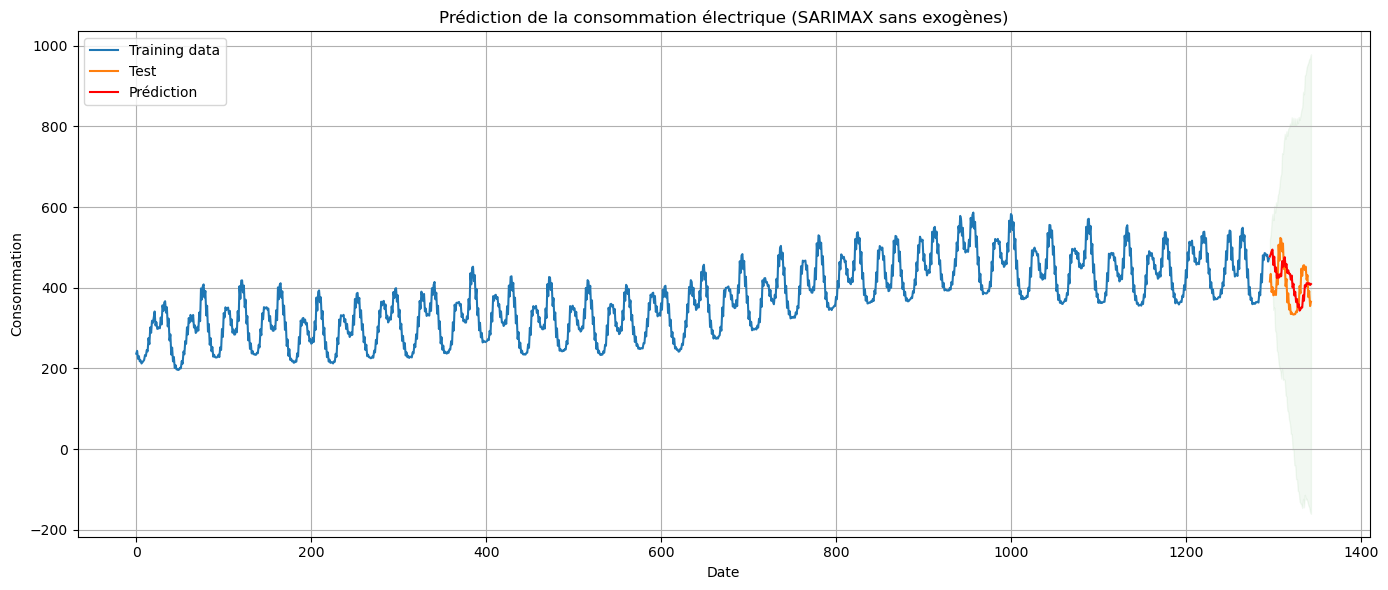

In [8]:
test = serie_annee.iloc[-test_long:]
forecast = results.get_forecast(steps=len(test))
prediction = pd.DataFrame(prediction, index=test.index)
conf_int = forecast.conf_int()


plt.figure(figsize=(14, 6))
plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(prediction, label='Prédiction', color='red')
plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='g', alpha=0.05)
plt.title("Prédiction de la consommation électrique (SARIMAX sans exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()

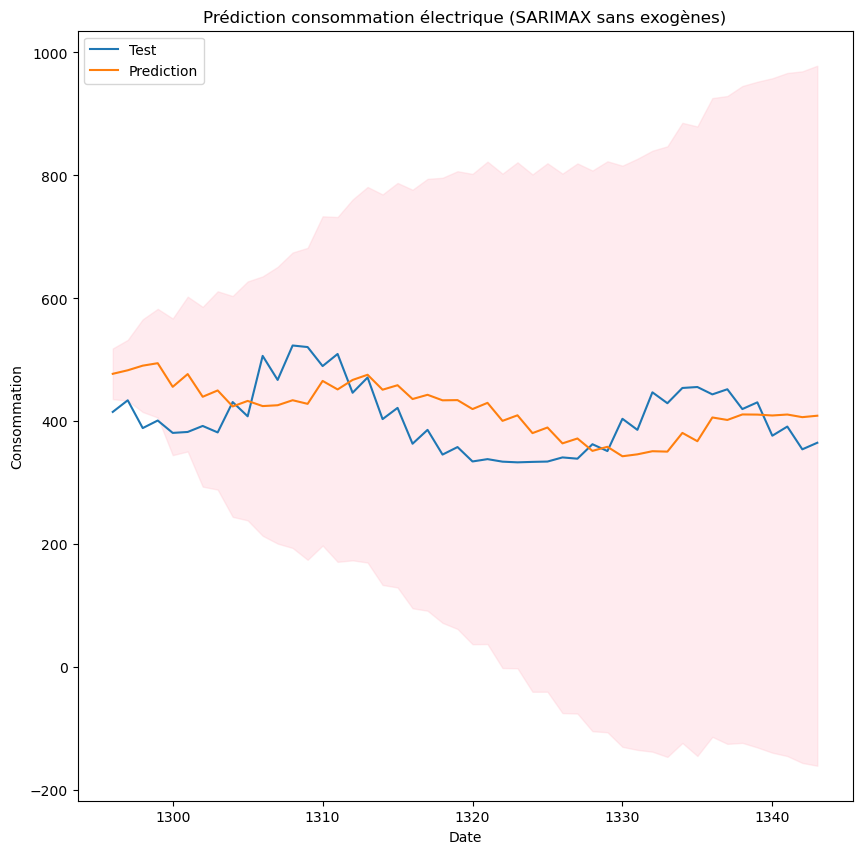

✅ MAE  = 54.38
✅ RMSE = 61.16
✅ MAPE = 13.66%


In [9]:
from sklearn.metrics import mean_absolute_percentage_error

plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(test, label ='Test')
plt.plot(prediction, label ="Prediction")

plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction consommation électrique (SARIMAX sans exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()


mae = mean_absolute_error(test, prediction)
rmse = np.sqrt(mean_squared_error(test, prediction))
mape = mean_absolute_percentage_error(test, prediction)

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
$Y_t$ : consommation éléctrique

Première décomposition  $Y_t= S^1_t\times\Theta^1_t\times R^1_t  $

En log :  $log(Y_t)= log(S^1_t)+ log(\Theta^1_t) + log(R^1_t)  $


Deuxième décomposition  $\Theta^1_t= S^2_t\times\Theta^2_t\times R^2_t  $

En log :  $log(Y_t)= log(S^1_t)+log(S^2_t) + log(\Theta^2_t) + log(R^2_t) + log(R^1_t)  $



troisème décomposition  $\Theta^2_t= S^3_t\times\Theta^3_t\times R^3_t  $

En log :  $log(Y_t)= log(S^1_t)+log(S^2_t) + +log(S^3_t) + log(\Theta^3_t) + log(R^3_t) + log(R^2_t) + log(R^1_t)  $


La composante $log(S^1_t)$ est quasi-périodique de période $P_1 = 48$ ==> très bonne approximation avec SARIMA(2,1,0)(1,1,0,48)

La composante $log(S^2_t)$ est quasi-périodique de période $P_2 = 7*48$

La composante $log(S^3_t)$ est quasi-périodique de période $P_3 = 365*48$

In [10]:
# Décomposition 

from statsmodels.tsa.seasonal import seasonal_decompose 
# Premier niveau de décomosition
decomposition_1 = seasonal_decompose(serie, period=48,  model='multiplicative', extrapolate_trend='freq') 
trend_1 = decomposition_1.trend
seasonal_1 = decomposition_1.seasonal
resid_1 = decomposition_1.resid


# Décomposition de la température²
decomposition_T = seasonal_decompose(serie_T, period=48,   extrapolate_trend='freq') #

# Affichage de la décomposition

#decomposition_2.plot()

In [ ]:

# Longueur séries  
forceast_long = 365*48
test_long = 2*48

X_1 =  seasonal_1.iloc[0: forceast_long] # par SARIMAX (2,1,1)(1,1,0,48)
X_2 =  trend_1.iloc[0: forceast_long]  #  RL par rapport à la 1/température  
X_3 =  resid_1.iloc[0: forceast_long]  # par SARIMAX (5,1,2)(1,1,0,14) 





# 


In [ ]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prediction de X_1

X_1_train = X_1.iloc[0:-test_long]
X_1_test =  X_1.iloc[-test_long:]

print("modèle...")
sarima_conso = SARIMAX(X_1_train.values,order=(2,1,1),
                      seasonal_order=(1,1,0,48),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
                      
print("entrainement...")
results_X_1 = sarima_conso.fit(disp=False)
print("prediction...")
forecast_X_1 = results_X_1.get_forecast(steps=len(X_1_test))
print("moyenne prediction ...")
X_1_prediction = forecast_X_1.predicted_mean
print("IC...")
conf_int = forecast_X_1.conf_int()





modèle...
entrainement...
prediction...
moyenne prediction ...
IC...


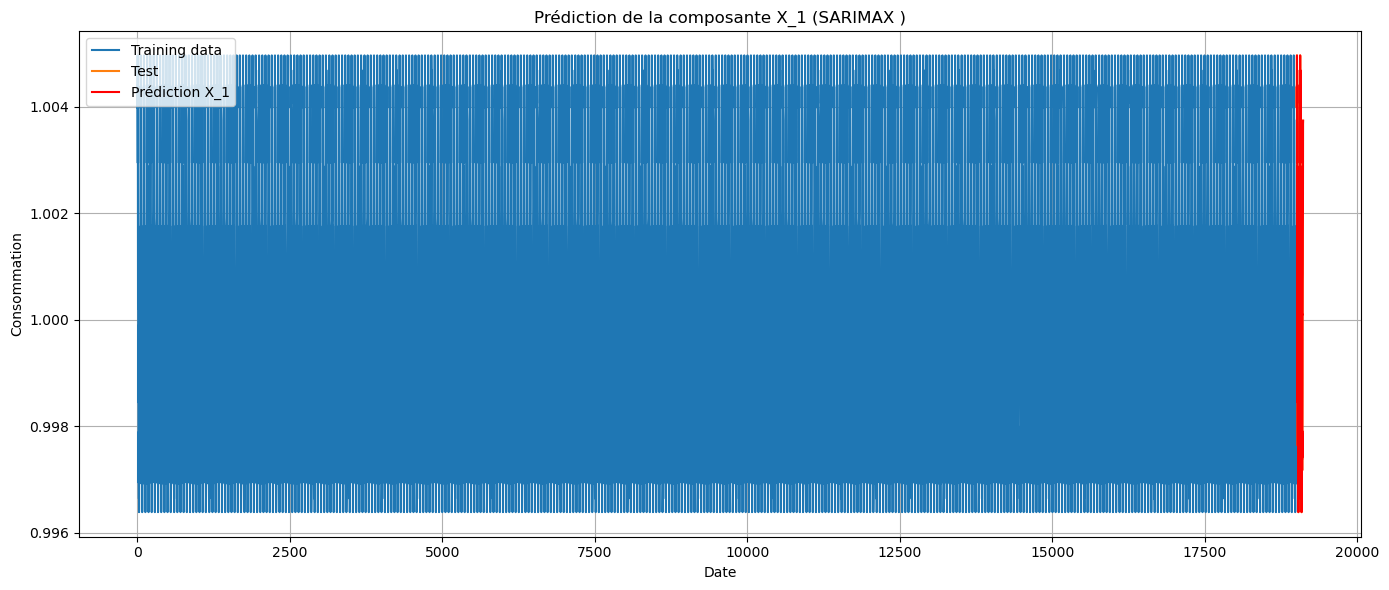

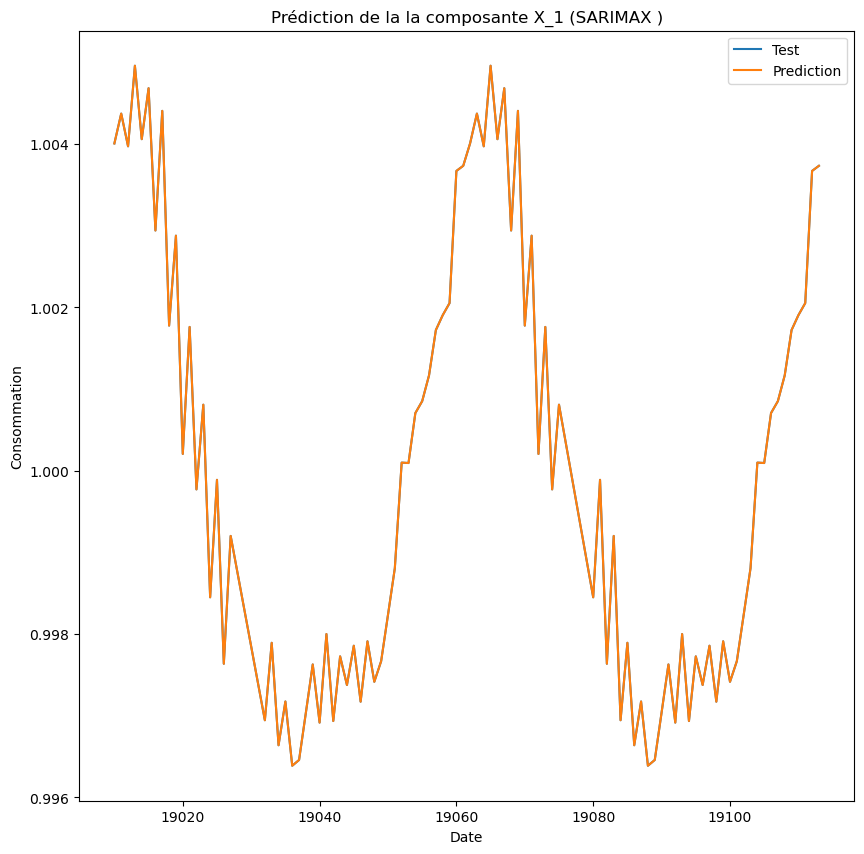

MAPE: 0.00%


In [ ]:
# Visualisation pour X_1 

X_1_prediction = pd.Series(X_1_prediction, index = X_1_test.index)

plt.figure(figsize=(14, 6))
plt.plot(X_1_train, label = 'Training data')
plt.plot(X_1_test, label ='Test')
plt.plot(X_1_prediction, label='Prédiction X_1', color='red')
plt.fill_between(X_1_prediction.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prédiction de la composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(X_1_test, label ='Test')
plt.plot(X_1_prediction, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de la la composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt


#Erreur mape 
mape = mean_absolute_percentage_error(X_1_test, X_1_prediction)
print(f"MAPE: {mape:.2%}")

In [14]:
# Prediction de X_3

X_3_train = X_3.iloc[0:-test_long]
X_3_test =  X_3.iloc[-test_long:]




print("modèle...")

sarima_conso = SARIMAX(X_3_train,
                      order=(5,1,2),
                      seasonal_order=(1,1,1,22),
                      enforce_stationarity=False,
                      enforce_invertibility=False,
                       disp=False)
                      
print("entrainement...")
results_X_3 = sarima_conso.fit(disp=False)
print("prediction...")
forecast_X_3= results_X_3.get_forecast(steps=len(X_3_test))
print("moyenne prediction ...")
X_3_prediction = forecast_X_3.predicted_mean
print("IC...")
#conf_int = forecast_resid_1.conf_int()

modèle...
entrainement...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['disp']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction...
moyenne prediction ...
IC...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


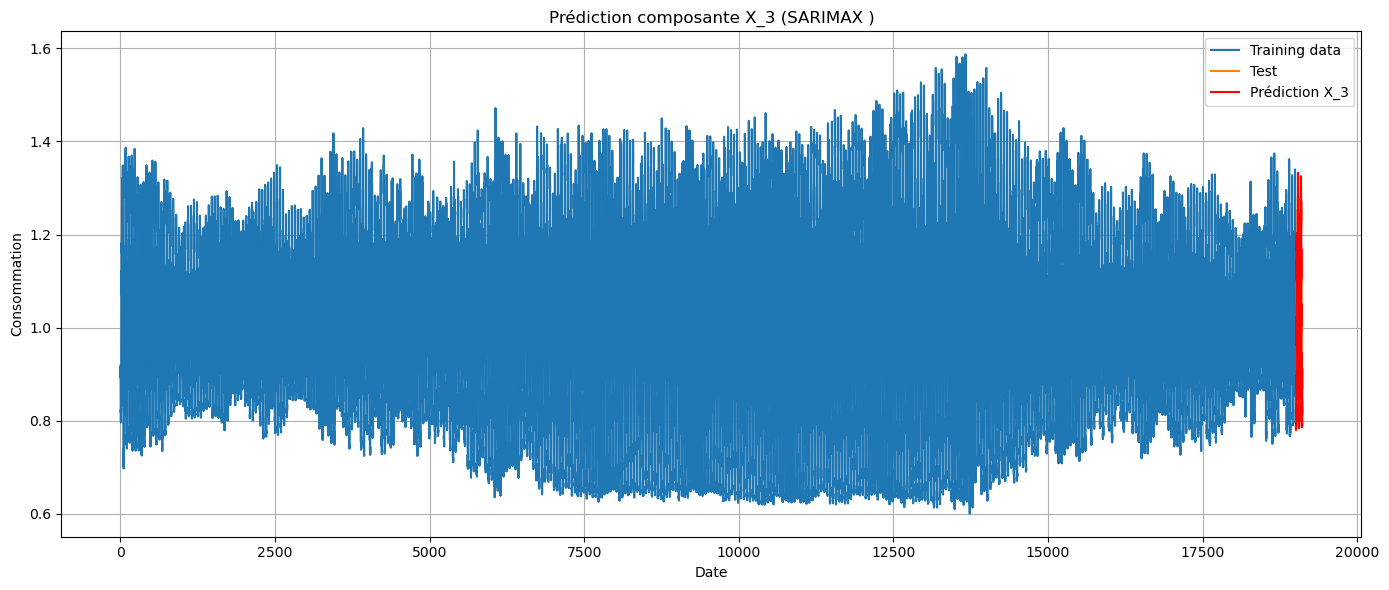

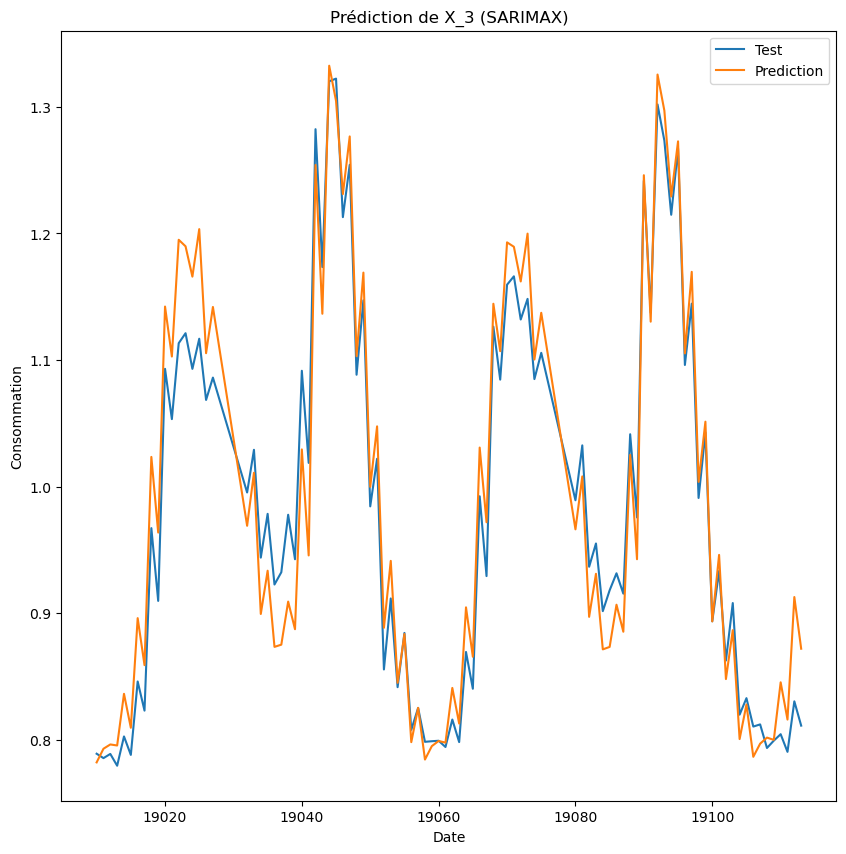

MAPE: 2.94%


In [15]:
# Affichage 
# Visualisation pour X_3
X_3_prediction = forecast_X_3.predicted_mean

X_3_prediction = pd.Series(X_3_prediction.values, index = X_3_test.index)

plt.figure(figsize=(14, 6))
plt.plot(X_3_train, label = 'Training data')
plt.plot(X_3_test, label ='Test')
plt.plot(X_3_prediction, label='Prédiction X_3', color='red')
#plt.fill_between(prediction_resid_1.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prédiction composante X_3 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




#Zoom sur la partie à prédire
plt.figure(figsize=(10,10))
plt.plot(X_3_test, label ='Test')
plt.plot(X_3_prediction, label ="Prediction")
plt.title("Prédiction de X_3 (SARIMAX)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()

mape = mean_absolute_percentage_error(X_3_test, X_3_prediction)
print(f"MAPE: {mape:.2%}")

In [16]:

# Prediction de X_2

X_2_train = X_2.iloc[0:-test_long].diff().dropna()
X_2_test =  X_2.iloc[-test_long:].diff().dropna()

T_train = serie_T.iloc[0: forceast_long-test_long].diff().dropna()
T_test = serie_T.iloc[forceast_long-test_long: forceast_long].diff().dropna()
T_train = 1 /(T_train + 40)
T_test = 1 /(T_test + 40)

print("modèle...")
sarima_conso = SARIMAX(X_2_train.values,order=(1,1,0),
                       seasonal_order=(1,1,0,22),
                       exog=T_train)
                      
print("entrainement...")
results_X_2 = sarima_conso.fit(disp=False)
print("prediction...")
forecast_X_2 = results_X_2.get_forecast(steps=len(X_2_test), exog=T_test)
print("moyenne prediction ...")
X_2_prediction = forecast_X_2.predicted_mean
print("IC...")
conf_int = forecast_X_2.conf_int()
X_2_prediction

modèle...
entrainement...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


prediction...
moyenne prediction ...
IC...


c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


17423   -0.194400
17424    0.102893
17425    0.520602
17426    0.773164
17427    1.376942
           ...   
17513    0.635747
17514    0.880399
17515    1.451414
17516    2.027570
17517    1.916197
Name: predicted_mean, Length: 95, dtype: float64

In [17]:
# Reconstitution
X_2_prediction = forecast_X_2.predicted_mean
print(X_2_prediction)
X_2_train = X_2.iloc[0:-test_long]
X_2_test =  X_2.iloc[-test_long:]
X_2_prediction_n = pd.Series(np.zeros(len(X_2_test)), index=X_2_test.index)
X_2_prediction_n.iloc[0] =  X_2_test.iloc[0]
for i in range(1,len(X_2_prediction)+1):
   X_2_prediction_n.iloc[i] = X_2_prediction.iloc[i-1] + X_2_prediction_n.iloc[i-1]
X_2_prediction = X_2_prediction_n
X_2_prediction

17423   -0.194400
17424    0.102893
17425    0.520602
17426    0.773164
17427    1.376942
           ...   
17513    0.635747
17514    0.880399
17515    1.451414
17516    2.027570
17517    1.916197
Name: predicted_mean, Length: 95, dtype: float64


date
19010    296.362191
19011    296.167791
19012    296.270684
19013    296.791286
19014    297.564450
            ...    
19109    292.686948
19110    293.567348
19111    295.018762
19112    297.046332
19113    298.962529
Length: 96, dtype: float64

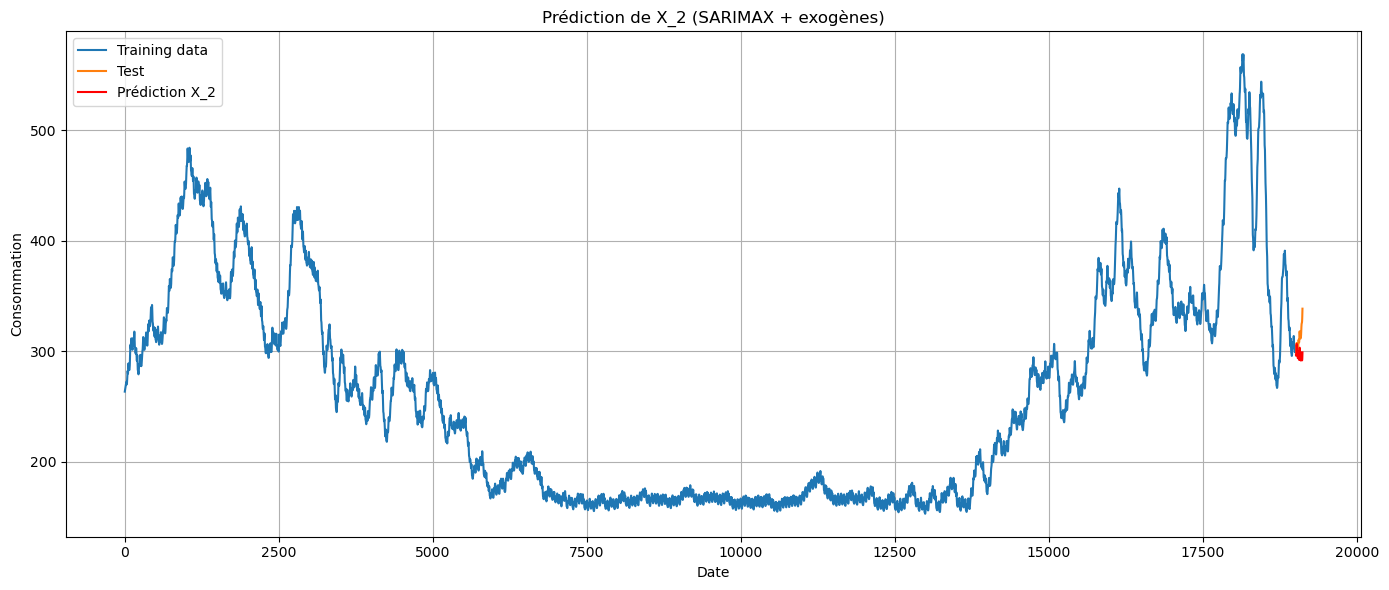

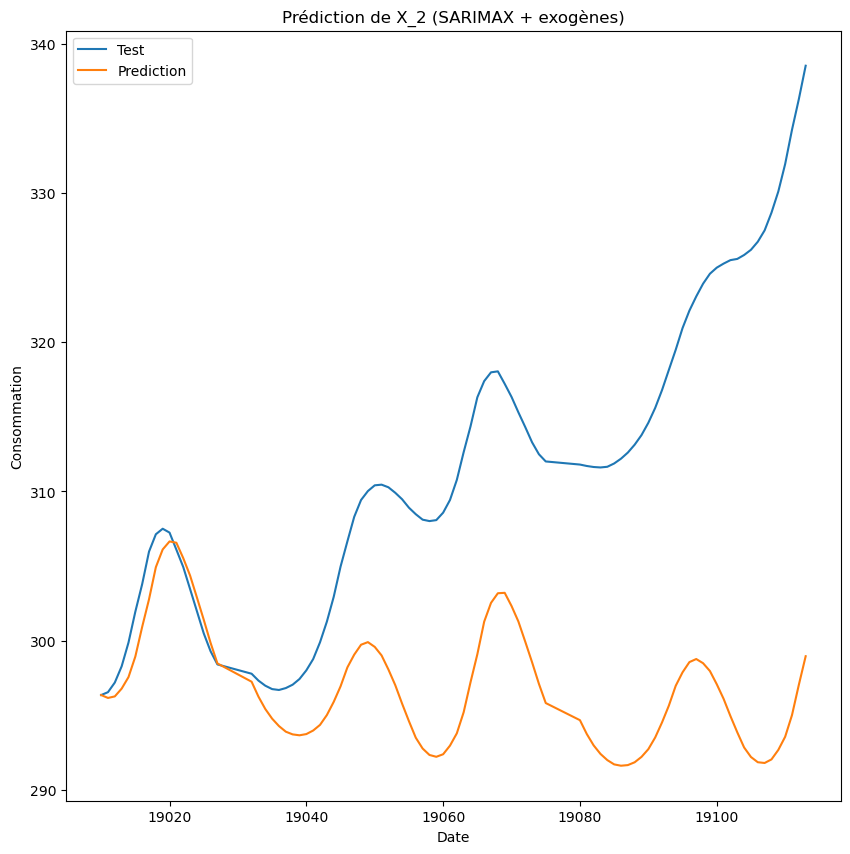

MAPE: 4.64%


In [18]:
# Visualisation pour X_2

#X_2_prediction = pd.Series(X_2_prediction, index = X_2_test.index)
#X_2_prediction.index = X_2_test.index
plt.figure(figsize=(14, 6))
plt.plot(X_2_train, label = 'Training data')
plt.plot(X_2_test, label ='Test')
plt.plot(X_2_prediction, label='Prédiction X_2', color='red')
#plt.fill_between(X_2_prediction.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prédiction de X_2 (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()



# MAP pour X_2
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(X_2_test, label ='Test')
plt.plot(X_2_prediction, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de X_2 (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()





mape = mean_absolute_percentage_error(X_2_test, X_2_prediction)
print(f"MAPE: {mape:.2%}")

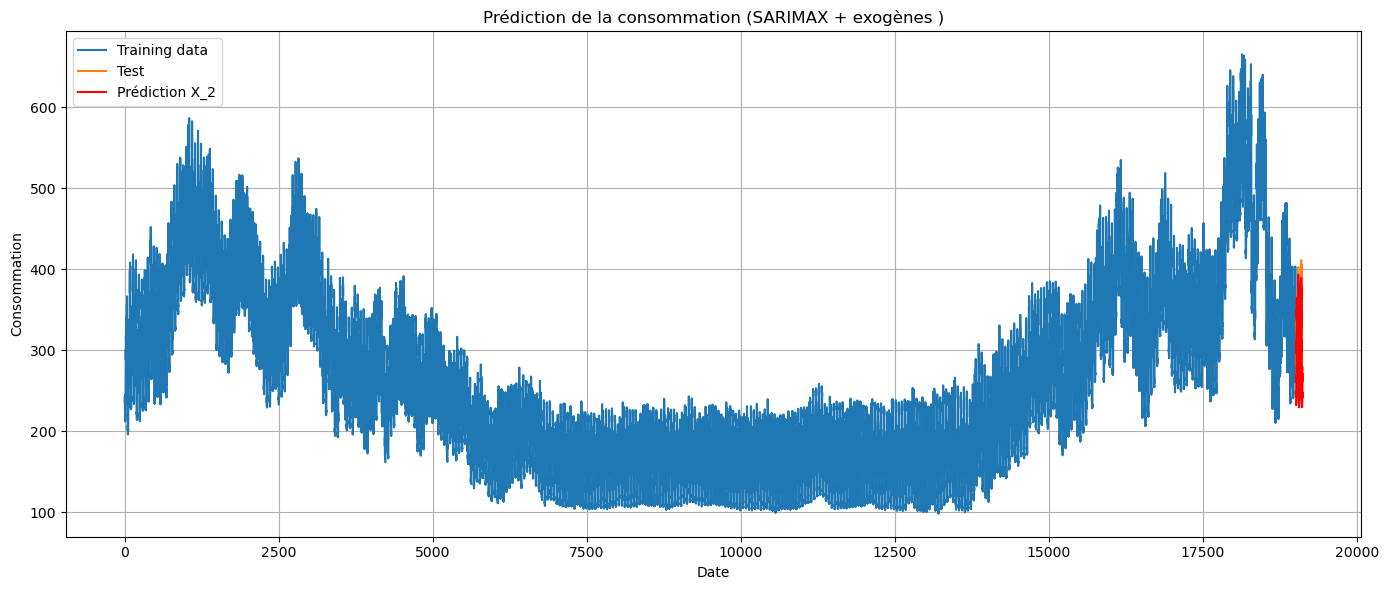

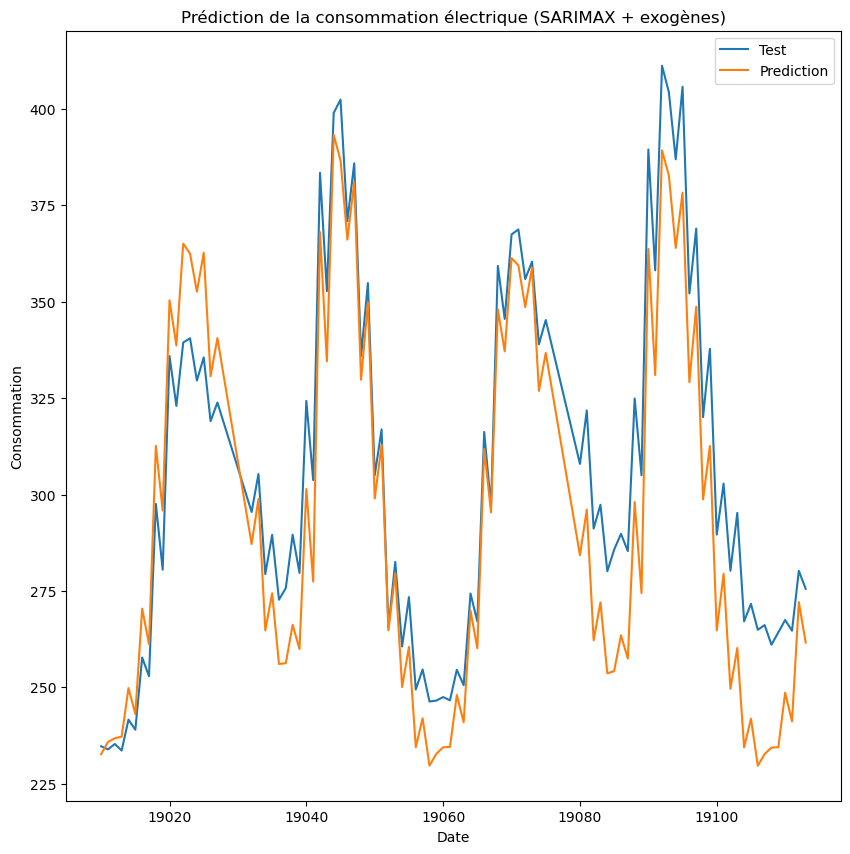

✅ MAE  = 16.37
✅ RMSE = 18.90
✅ MAPE = 5.43%


In [19]:
# prediction globale  X_1*X_2*X_3

serie1 = pd.Series(serie['consommation'], index=serie.index)
serie1 = serie1.iloc[0:forceast_long]
serie_train = serie1.iloc[0:-test_long] # X_1_train*X_2_train*X_3_train # serie.iloc[0:-test_long]
serie_test =serie1.iloc[-test_long:]  #  X_1_test*X_2_test*X_3_test #serie.iloc[-test_long:]

serie_prediction = pd.Series((X_1_prediction*X_2_prediction*X_3_prediction).values, index = serie_test.index)



plt.figure(figsize=(14, 6))
plt.plot(serie_train, label = 'Training data')
plt.plot(serie_test, label ='Test')
plt.plot(serie_prediction, label='Prédiction X_2', color='red')
#plt.fill_between(serie_prediction.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prédiction de la consommation (SARIMAX + exogènes )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()



# MAP pour X_2
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(serie_test, label ='Test')
plt.plot(serie_prediction, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de la consommation électrique (SARIMAX + exogènes)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()





# Métriques
mae = mean_absolute_error(serie_test, serie_prediction)
rmse = np.sqrt(mean_squared_error(serie_test, serie_prediction))
mape = mean_absolute_percentage_error(serie_test, serie_prediction)

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")

In [60]:
# Prédiction de X_2 par NN regression

# Packages 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM

from sklearn.model_selection import train_test_split

# Préparation du DataFrame 
df = sub_df.copy() #on copie les dataframe avec toute sles variables explicatives 

df["y"] = trend_1.values # la cible est la tendence de la consommation normalisée par le nombre de points de soutirage


# Construction du timestamp 'ds' : peut être utile si on introduit des fct trigo pour la périodicité
df['ds'] = pd.to_datetime(df['date'] + ' ' + df['h'].astype(str) + ':' + df['mn'].astype(str))

# Renommer la cible
df = df.rename(columns={
    "T_moyenne": "T",
    "U_moyenne": "U",
    "FF_moyenne": "FF",
    "Nb points soutirage": "Nb"
})

# Garder uniquement les variables exogènes (regressors)
df = df[[ 'y', 'T', 'U', 'FF']].dropna().drop_duplicates()

# Séparation des variables
X = df.drop(columns='y')
y = df['y']


X = X.iloc[0: forceast_long]
y = y.iloc[0: forceast_long]


X['T'] = 1/(X['T']+40)
# Normalisation
from sklearn import preprocessing
minmax_scaler = preprocessing.MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X)



# séparation test & entrainement 
#X_train = X_scaled[:-test_long]
#X_test = X_scaled[-test_long:]

#y_train = y[:-test_long]
#y_test = y[-test_long:]

# Modèle DNN 
# Architecture 
# Couche d'entrée
#dnn_model  = Sequential([Input(shape=(3,))])

# Couche 1 & 2  
#dnn_model.add(Dense(units=128, activation="tanh")) 
#dnn_model.add(Dense(units=64, activation="tanh"))

# Couche de sortie
#dnn_model.add(Dense(units=1)) 


# Modèle 2 
def create_sequences(df, window_size):
    #X, y = [], []
    X = []
    for i in range(window_size, len(df)):
        X.append(df[i-window_size:i, :-1])
        #y.append(yin[i])  # Consommation comme cible
    return np.array(X)

window_size = 24  #  48 pas (24 heures  * 2 intervalle de 30 minutes)

X_scaled_sequenced = create_sequences(X_scaled,window_size)




# séparation test & entrainement 
X_train = X_scaled_sequenced[:-test_long]
X_test = X_scaled_sequenced[-test_long:]

y_train = y[:-test_long]
y_test = y[-test_long:]



dnn_model = Sequential([LSTM(64, input_shape =(X_scaled_sequenced.shape[1], X_scaled_sequenced.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(64, activation='relu'),
        Dropout(0.2),
        Dense(1)])


# Résumé du modèle
dnn_model.summary()


lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Compilation du modèle

opt_1 = tf.optimizers.Adam(learning_rate=0.01)
dnn_model.compile(loss="mean_absolute_error",
             optimizer=opt_1,
             metrics=["mape"])

params = {'validation_split' : 0.2 , 'epochs' : 100, 'batch_size' : 32} 

dnn_history = dnn_model.fit(X_train, y_train,
         validation_split=params['validation_split'],
         epochs=params['epochs'], 
         batch_size=params['batch_size'],
         callbacks=[early_stopping, lr_scheduler])



# Prédiction
y_pred =  dnn_model.predict(X_test).flatten()
X_2_prediction_dnn = y_pred 






D:\Temp\ipykernel_9952\2806131400.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['date'] + ' ' + df['h'].astype(str) + ':' + df['mn'].astype(str))
c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 24, 64)         │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,241 (196.25 KB)

 Trainable params: 50,241 (196.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 232.0941 - mape: 95.4711 - val_loss: 47.8244 - val_mape: 13.1820 - learning_rate: 0.0100
Epoch 2/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 47.9232 - mape: 20.6565 - val_loss: 70.4616 - val_mape: 19.5455 - learning_rate: 0.0100
Epoch 3/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 45.2299 - mape: 19.3854 - val_loss: 59.1944 - val_mape: 15.9394 - learning_rate: 0.0100
Epoch 4/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 43.3307 - mape: 18.5460 - val_loss: 75.5470 - val_mape: 20.8852 - learning_rate: 0.0100
Epoch 5/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 44.4165 - mape: 18.7968 - val_loss: 68.0718 - val_mape: 18.6363 - learning_rate: 0.0100
Epoch 6/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 44.2885 - mape: 18.8409 - val_loss: 52.3666 - val_mape: 14.5586 - learning_rate: 0.0100
Epoch 7/100
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 41.2780 - mape: 17.4036 - val_loss: 60.6822 

In [54]:
X_2_prediction_dnn

array([316.16055, 318.20773, 320.59387, 323.96683, 329.82724, 334.2571 ,
       343.52133, 346.33804, 352.54605, 353.9319 , 357.0023 , 357.4728 ,
       358.88498, 358.16425, 357.76318, 356.23032, 354.42206, 352.42703,
       349.76114, 347.61594, 344.3971 , 342.0103 , 338.77182, 337.22003,
       335.35727, 334.3345 , 332.48187, 331.70776, 330.5881 , 329.7643 ,
       328.66898, 327.86548, 326.6191 , 325.3691 , 323.69693, 322.2737 ,
       320.61334, 319.505  , 317.6052 , 316.27304, 311.08337, 311.1721 ,
       310.74985, 311.2086 , 311.46457, 312.37332, 313.36325, 314.78638,
       316.91824, 318.88278, 322.21844, 324.2604 , 327.68906, 329.61588,
       333.01352, 334.61652, 337.68875, 338.9218 , 341.2754 , 342.20865,
       343.40247, 344.69058, 346.5977 , 347.58524, 348.9916 , 349.36697,
       350.51572, 350.81256, 351.92044, 352.1124 , 352.69205, 352.40115,
       352.19272, 352.0566 , 352.13132, 352.52866, 352.6767 , 353.17868,
       353.49078, 353.8722 , 354.08218, 354.74115, 

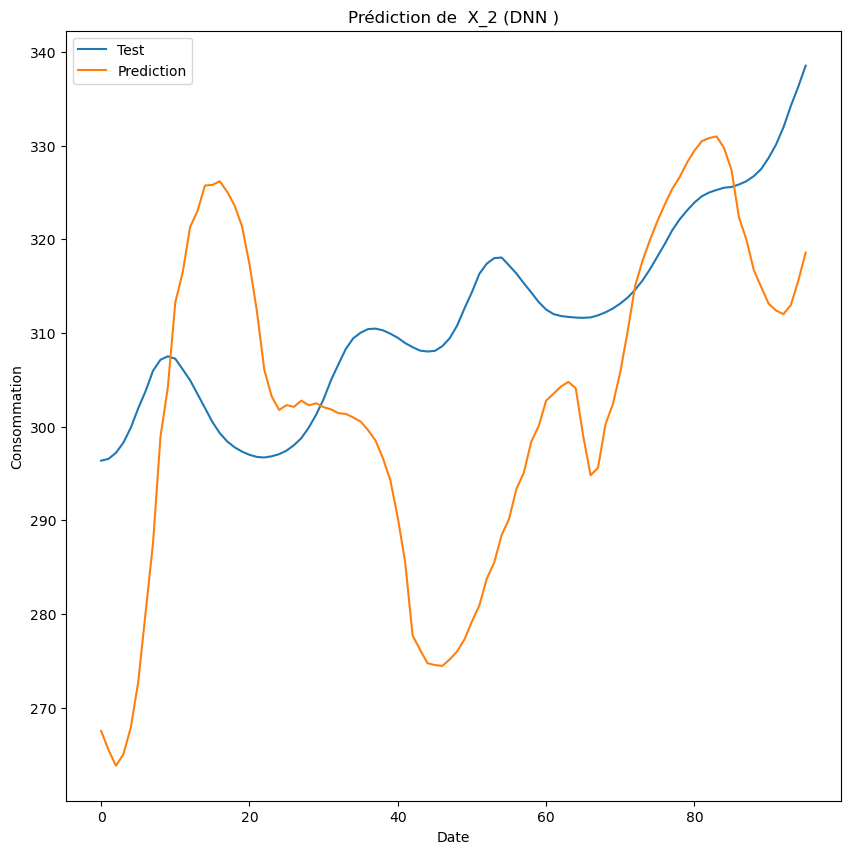

In [61]:
# # Affichage pour X_2 prédit par DNN


# MAP pour X_2
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(y_test.values, label ='Test')
plt.plot(y_pred, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de  X_2 (DNN )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()

plt.show()





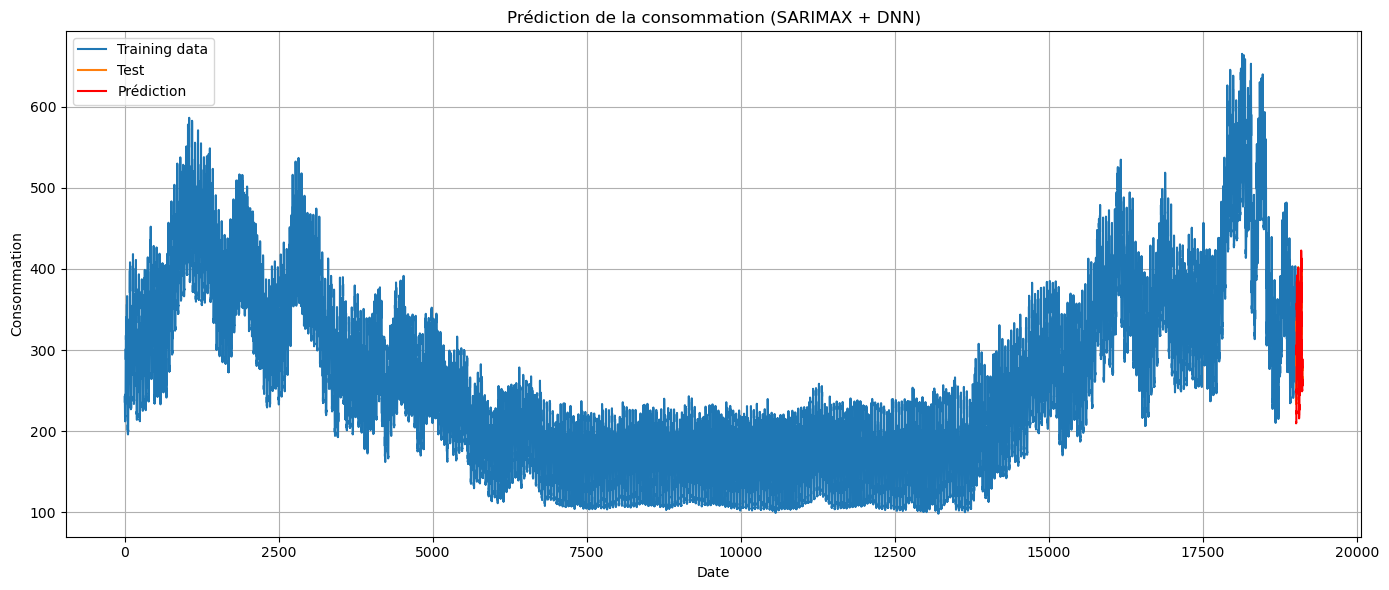

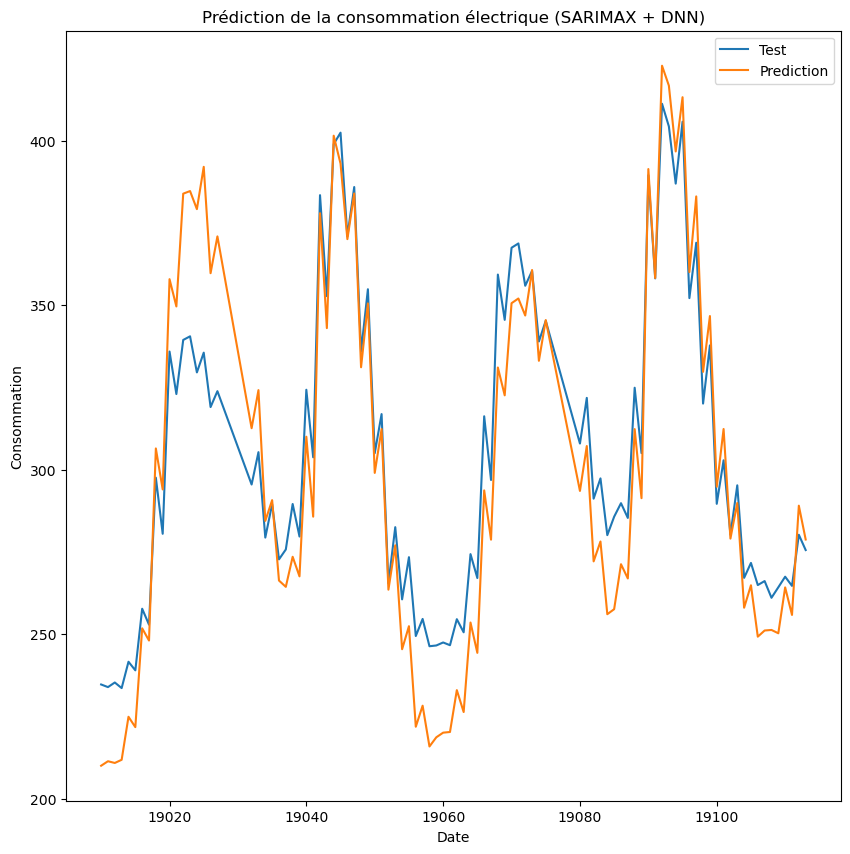

✅ MAE  = 15.45
✅ RMSE = 19.26
✅ MAPE = 5.27%


In [62]:
# prediction globale  X_1*X_2*X_3


serie1 = pd.Series(serie['consommation'], index=serie.index)
serie1 = serie1.iloc[0:forceast_long]
serie_train = serie1.iloc[0:-test_long] # X_1_train*X_2_train*X_3_train # serie.iloc[0:-test_long]
serie_test =serie1.iloc[-test_long:]  #  X_1_test*X_2_test*X_3_test #serie.iloc[-test_long:]

serie_prediction = pd.Series((X_1_prediction*X_2_prediction_dnn*X_3_prediction).values, index = serie_test.index)



plt.figure(figsize=(14, 6))
plt.plot(serie_train, label = 'Training data')
plt.plot(serie_test, label ='Test')
plt.plot(serie_prediction, label='Prédiction', color='red')
#plt.fill_between(serie_prediction.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prédiction de la consommation (SARIMAX + DNN)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 
plt.show()



# MAP pour X_2
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(serie_test, label ='Test')
plt.plot(serie_prediction, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de la consommation électrique (SARIMAX + DNN)")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()


mape = mean_absolute_percentage_error(serie_test, serie_prediction)
# Métriques
mae = mean_absolute_error(serie_test, serie_prediction)
rmse = np.sqrt(mean_squared_error(serie_test, serie_prediction))
mape = mean_absolute_percentage_error(serie_test, serie_prediction)

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")

saisonnalite_24
saisonnalite_48
saisonnalite_336


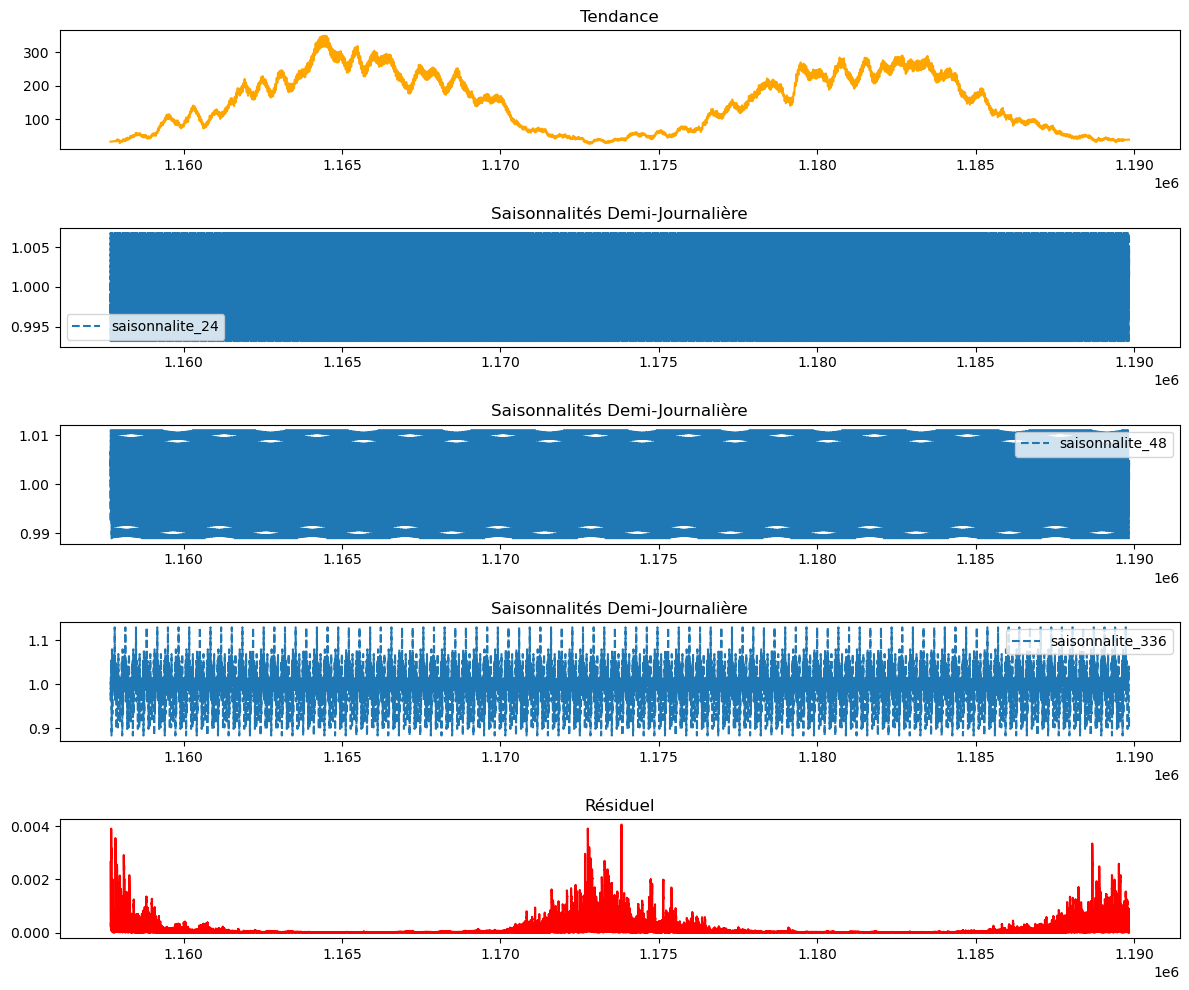

saisonnalite_24
saisonnalite_48
saisonnalite_336


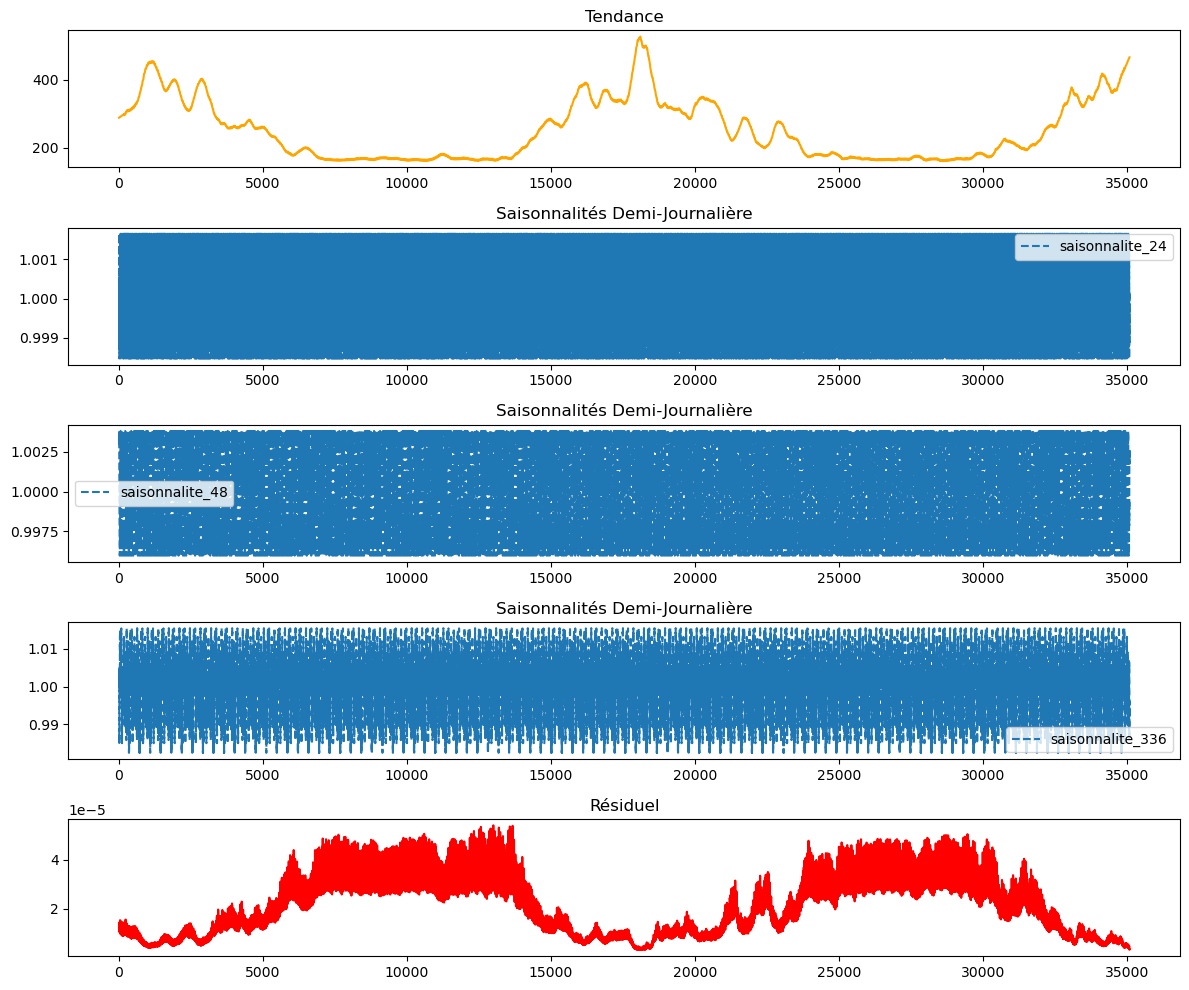

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.base import BaseEstimator, TransformerMixin

class DecompositionSerieTemporelle1(BaseEstimator, TransformerMixin):
    def __init__(self, colonne, periodes, forme = 'multiplicative') :
        self.forme = forme
        self.colonne = colonne
        self.periodes = periodes
        self.saisonnalite = pd.DataFrame({})
        self.tendance = None
        self.residuel = None
        



    def fit(self, X, y=None):
        if np.min(X[self.colonne]) <= 0 :
            y = X[self.colonne] - np.min(X[self.colonne]) + 1
        else :
            y = X[self.colonne]

        # Décomposition STL avec les trois périodicités
        if self.forme == 'additive':
            premier_niveau_decomposition = True
    
            for periode in self.periodes :
                # Décomposition en commençant par la plus petite période
                # Noms des variables
                saisonnalite_varname = 'saisonnalite_' + str(periode)
                # Décomposition additive              
                if (premier_niveau_decomposition):
                    premier_niveau_decomposition = False
                    y_decompose  = seasonal_decompose(y, period=periode, extrapolate_trend='freq')
                    y_detrended = y - y_decompose
                    # On récupère la composante de saisonnalité 
                    self.saisonnalite[saisonnalite_varname] = y_decompose.seasonal
                    # On calcule le résiduel
                    self.residuel = y-y_decompose.seasonal
                else:
                    y_decompose  = seasonal_decompose(y_detrended, period=periode,  extrapolate_trend='freq')
                    y_detrended = y - y_decompose.seasonal
                    # On récupère la composante de saisonnalité 
                    self.saisonnalite[saisonnalite_varname] = y_decompose.seasonal
                     # On calcule le résiduel
                    self.residuel = y - y_decompose.seasonal
                
                #La tendance est celle de la dernière décomposition
                self.tendance = y_decompose.trend
                # On calcule le résiduel final en divisant le résiduel par cette dernière tendance
                self.residuel = self.residuel-self.tendance
        
        if self.forme == 'multiplicative':
             premier_niveau_decomposition = True

             for periode in self.periodes :
                # Décomposition en commençant par la plus petite période
                # Décomposition multiplicative
                # Noms des variables
                saisonnalite_varname = 'saisonnalite_' + str(periode)
                if (premier_niveau_decomposition):
                    premier_niveau_decomposition = False
                    y_decompose   = seasonal_decompose(y, period=periode, model='multiplicative', extrapolate_trend='freq')
                    # On récupère la composante de saisonnalité 
                    self.saisonnalite[saisonnalite_varname] = y_decompose.seasonal
                    # On calcule le résiduel
                    self.residuel = y / y_decompose.seasonal
                    # y sans saisonnalité
                    y_detrended = y / y_decompose.seasonal
             
                else:
                    y_decompose  = seasonal_decompose(y_detrended, period=periode, model='multiplicative', extrapolate_trend='freq')
                    # On récupère la composante de saisonnalité 
                    self.saisonnalite[saisonnalite_varname] = y_decompose.seasonal
                    self.residuel = self.residuel / y_decompose.seasonal
                    # on divise par la nouvelle saisonnalité 
                    y_detrended = y_detrended / y_decompose.seasonal
                   
                #La tendance est celle de la dernière décomposition
            self.tendance = y_decompose.trend
                # On calcule le résiduel final en divisant le résiduel par cette dernière tendance
            self.residuel = self.residuel/self.tendance
        return self

    def transform(self, X):


        X_copy = X.copy()
        X_copy['tendance'] = self.tendance
        X_copy['residuel'] = self.residuel
        for col in self.saisonnalite.columns:
            print(col)
            X_copy[col] = self.saisonnalite[col]
        return X_copy

    def plot_decomposition(self):
        nb_subplot = len(self.periodes) + 2
        plt.figure(figsize=(12, 10))
        plt.subplot(nb_subplot, 1, 1)
        plt.plot(self.tendance, label='Tendance', color='orange')
        plt.title('Tendance')
        
        indx = 2
        for col in self.saisonnalite.columns:
            plt.subplot(nb_subplot, 1, indx) # indexe + 2 figure 1 pour la tendance 
            plt.plot(self.saisonnalite[col], label=col, linestyle='--')
            plt.title('Saisonnalités Demi-Journalière')
            plt.legend()
            indx = indx + 1

        plt.subplot(nb_subplot, 1, nb_subplot)
        plt.plot(self.residuel, label='Résiduel', color='red')
        plt.title('Résiduel')

        plt.tight_layout()
        plt.show()
# Exemple d'utilisation
if __name__ == "__main__":
    # Chargement de la série temporelle
    d = {'date': X_2_train.index, 'consommation': X_2_train.values}
    S = pd.DataFrame(d)
    XX = sub_df #serie_T + 40
    #decomposer = DecompositionSerieTemporelle(colonne='consommation', forme = 'multiplicative')
    decomposer = DecompositionSerieTemporelle1(colonne='Rayonnement solaire global (W/m2)', forme = 'multiplicative', periodes = [24,48,336])
    decomposer.fit(XX)
    df_transforme = decomposer.transform(XX)
    decomposer.plot_decomposition()


    S = pd.DataFrame(d)
    XX = serie
    decomposer = DecompositionSerieTemporelle1(colonne='consommation', forme = 'multiplicative',periodes = [24,48,336])
    decomposer.fit(XX)
    df_transforme = decomposer.transform(XX)
    decomposer.plot_decomposition()

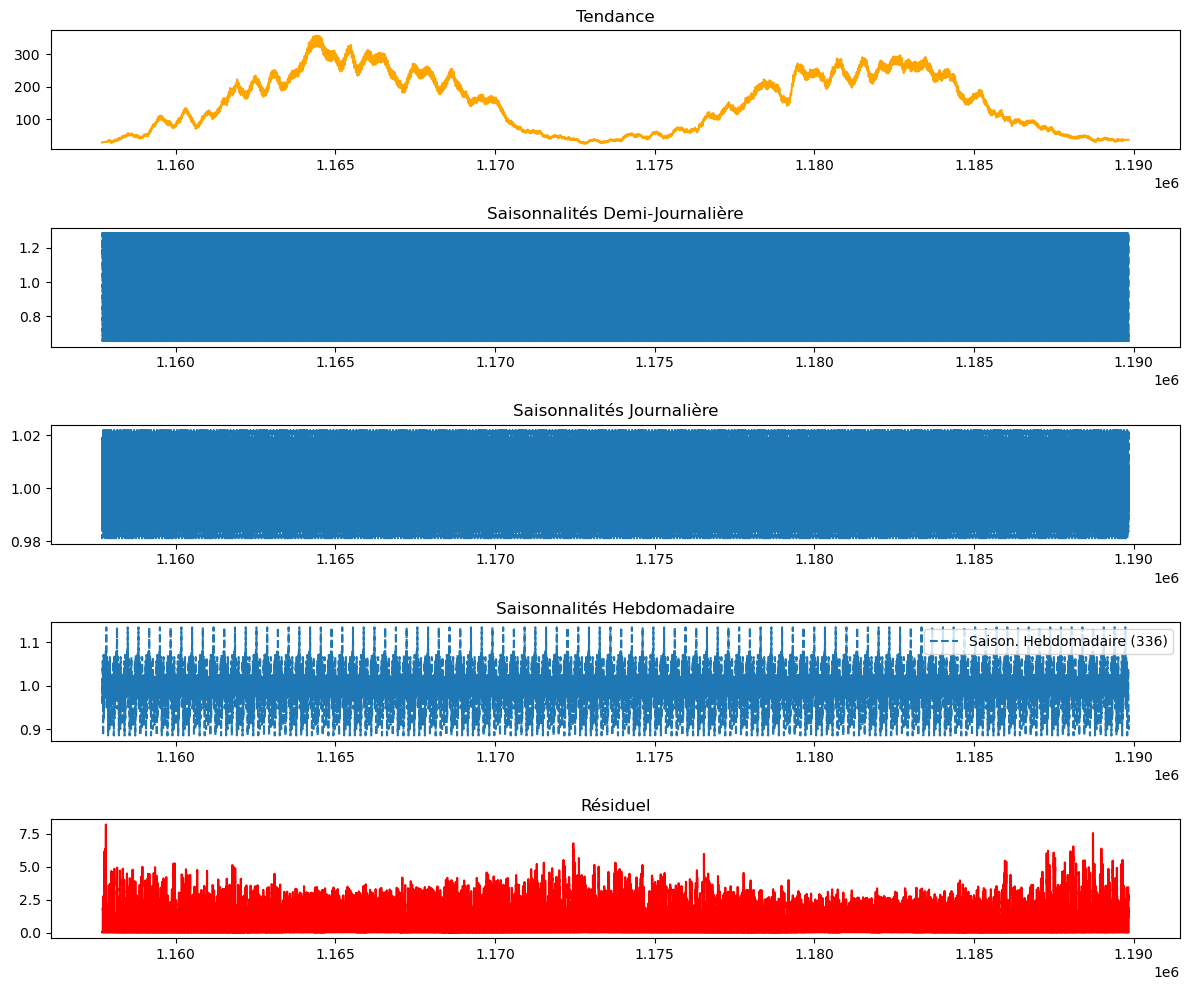

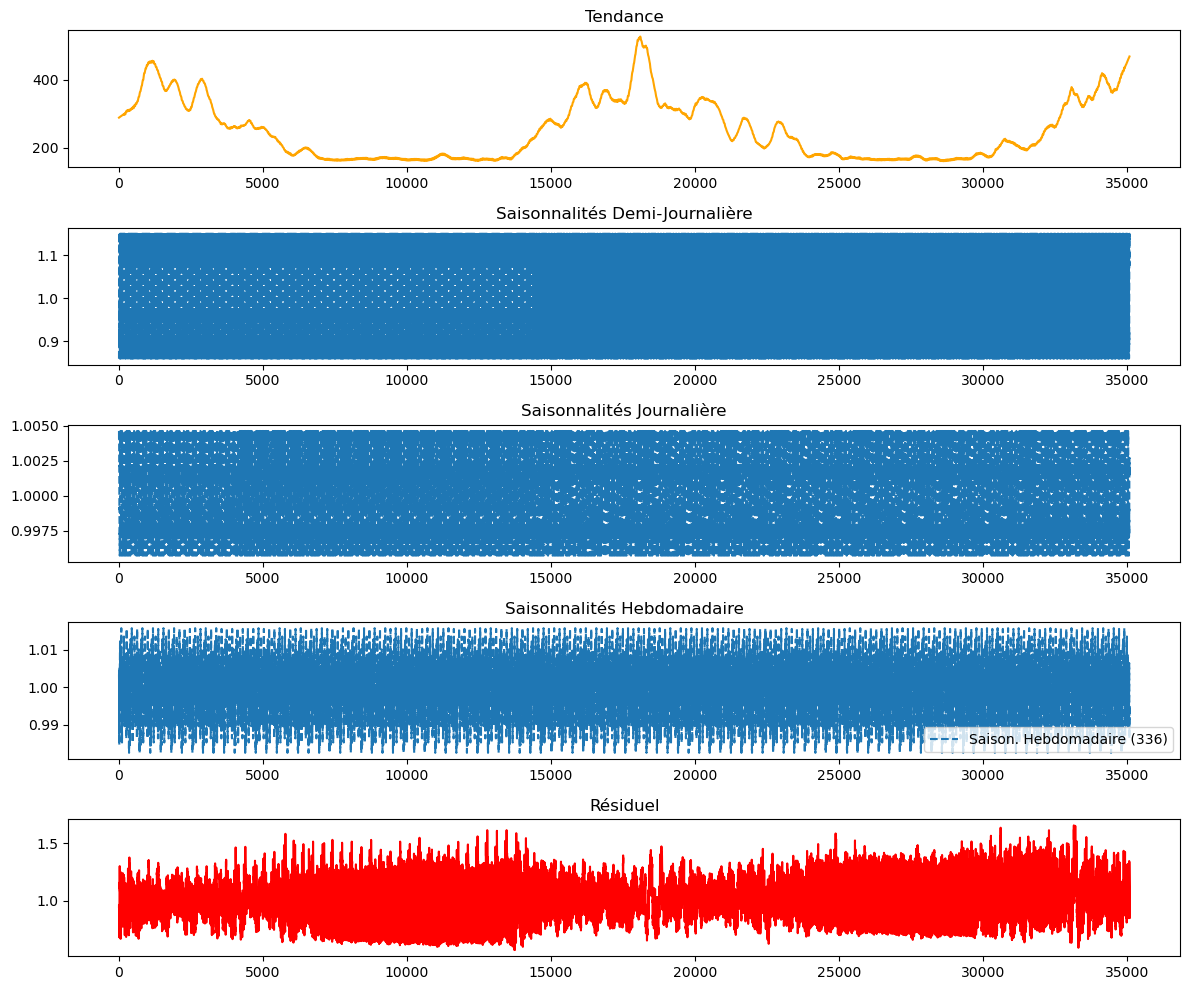

In [636]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

from statsmodels.tsa.seasonal import seasonal_decompose 
# Premier niveau de décomosition

from sklearn.base import BaseEstimator, TransformerMixin

class DecompositionSerieTemporelle(BaseEstimator, TransformerMixin):
    def __init__(self, colonne, forme = 'multiplicative') :
        self.forme = forme
        self.colonne = colonne
        self.tendance = None
        self.residuel = None
        self.saisonnalite_22 = None
        self.saisonnalite_48 = None
        self.saisonnalite_336 = None

    def fit(self, X, y=None):
        if np.min(X[self.colonne]) <= 0 :
            y = X[self.colonne] - np.min(X[self.colonne]) + 1
        else :
            y = X[self.colonne]

        # Décomposition STL avec les trois périodicités
        if self.forme == 'additive':
            # Décomposition successive
            # 1. Première décomposition avec la saisonnalité 336 (hebdomadaire)
            decompose_336 = seasonal_decompose(y, model=self.model, period=336)
            y_detrended_336 = y / decompose_336.seasonal if self.model == 'multiplicative' else y - decompose_336.seasonal

            # 2. Décomposition de la série détrendée (saisonnalité 48)
            decompose_48 = seasonal_decompose(y_detrended_336, model=self.model, period=48)
            y_detrended_48 = y_detrended_336 - decompose_48.seasonal

            # 3. Décomposition de la série détrendée (saisonnalité 22)
            decompose_22 = seasonal_decompose(y_detrended_48, model=self.model, period=22)

            # Stockage des composantes
            self.tendance = decompose_336.trend
            self.saisonnalite_336 = decompose_336.seasonal
            self.saisonnalite_48 = decompose_48.seasonal
            self.saisonnalite_22 = decompose_22.seasonal

             # Calcul du résiduel final
            self.residuel =  y - (self.tendance + self.saisonnalite_22 + self.saisonnalite_48 + self.saisonnalite_336)
        
        if self.forme == 'multiplicative':
            # Transformation logarithmique pour la décomposition multiplicative
            decompose_22 = seasonal_decompose(y, period=22, model='multiplicative', extrapolate_trend='freq')
            y_detrended_22 = y/decompose_22.seasonal
            decompose_48 = seasonal_decompose(y_detrended_22, period=48, model='multiplicative', extrapolate_trend='freq')
            y_detrended_48 = y_detrended_22/decompose_48.seasonal # y//decompose_48.seasonal
            decompose_336 = seasonal_decompose(y_detrended_48, period=7 * 48, model='multiplicative', extrapolate_trend='freq')

            # Stockage des composantes multiplicatives (exponentiation)
            self.tendance = decompose_336.trend
            self.saisonnalite_22 = decompose_22.seasonal
            self.saisonnalite_48 =decompose_48.seasonal
            self.saisonnalite_336 = decompose_336.seasonal
            self.residuel = y / (self.tendance *self.saisonnalite_22*self.saisonnalite_48*self.saisonnalite_336)
        
        """
        
        if self.forme == 'additive':

            # Décomposition STL avec les trois périodicités
            stl_22 = STL(y, period=22, seasonal=13).fit()
            stl_48 = STL(y, period=48, seasonal=13).fit()
            stl_336 = STL(y, period=7 * 48, seasonal=13).fit()

            # Stockage des composantes
            self.tendance = (stl_22.trend + stl_48.trend + stl_336.trend) / 3
            self.saisonnalite_22 = stl_22.seasonal
            self.saisonnalite_48 = stl_48.seasonal
            self.saisonnalite_336 = stl_336.seasonal
            self.residuel = y - self.tendance - (self.saisonnalite_22 + self.saisonnalite_48 + self.saisonnalite_336)

        if self.forme == 'multiplicative':
            # Transformation logarithmique pour la décomposition multiplicative
            y_log = y.apply(lambda x: x if x > 0 else 1).apply(lambda x: np.log(x))

            # Décomposition STL avec les trois périodicités
            stl_22 = STL(y_log, period=22, seasonal=13).fit()
            stl_48 = STL(y_log, period=48, seasonal=13).fit()
            stl_336 = STL(y_log, period=7 * 48, seasonal=13).fit()

            # Stockage des composantes multiplicatives (exponentiation)
            self.tendance = np.exp((stl_22.trend + stl_48.trend + stl_336.trend) / 3)
            self.saisonnalite_22 = np.exp(stl_22.seasonal)
            self.saisonnalite_48 = np.exp(stl_48.seasonal)
            self.saisonnalite_336 = np.exp(stl_336.seasonal)
            self.residuel = y / (self.tendance * self.saisonnalite_22 * self.saisonnalite_48 * self.saisonnalite_336)
        """
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['tendance'] = self.tendance
        X_copy['residuel'] = self.residuel
        X_copy['saisonnalite_22'] = self.saisonnalite_22
        X_copy['saisonnalite_48'] = self.saisonnalite_48
        X_copy['saisonnalite_336'] = self.saisonnalite_336
        return X_copy

    def plot_decomposition(self):
        plt.figure(figsize=(12, 10))

        plt.subplot(5, 1, 1)
        if self.colonne == 'T_moyenne':
            plt.plot(1/self.tendance, label='Tendance', color='orange')
        else:
            plt.plot(self.tendance, label='Tendance', color='orange')
        plt.title('Tendance')

        plt.subplot(5, 1, 2)
        plt.plot(self.saisonnalite_22, label='Saison. Demi-Journalière (22)', linestyle='--')
        plt.title('Saisonnalités Demi-Journalière')
        
        plt.subplot(5, 1, 3)
        plt.plot(self.saisonnalite_48, label='Saison. Journalière (48)', linestyle='--')
        plt.title('Saisonnalités Journalière')
        
        plt.subplot(5, 1, 4)
        plt.plot(self.saisonnalite_336, label='Saison. Hebdomadaire (336)', linestyle='--')
        plt.title('Saisonnalités Hebdomadaire')

        plt.legend()

        plt.subplot(5, 1, 5)
        plt.plot(self.residuel, label='Résiduel', color='red')
        plt.title('Résiduel')

        plt.tight_layout()
        plt.show()

# Exemple d'utilisation
if __name__ == "__main__":
    # Chargement de la série temporelle
    d = {'date': X_2_train.index, 'consommation': X_2_train.values}
    S = pd.DataFrame(d)
    XX = sub_df #serie_T + 40
    #decomposer = DecompositionSerieTemporelle(colonne='consommation', forme = 'multiplicative')
    decomposer = DecompositionSerieTemporelle(colonne='Rayonnement solaire global (W/m2)', forme = 'multiplicative')
    decomposer.fit(XX)
    df_transforme = decomposer.transform(XX)
    decomposer.plot_decomposition()


    S = pd.DataFrame(d)
    XX = serie
    decomposer = DecompositionSerieTemporelle(colonne='consommation', forme = 'multiplicative')
    decomposer.fit(XX)
    df_transforme = decomposer.transform(XX)
    decomposer.plot_decomposition()


In [134]:

decomposer.fit(serie)
serie_transforme = decomposer.transform(serie)
X_1 =  serie_transforme.saisonnalite_22.iloc[0: forceast_long] # par SARIMAX (2,1,1)(1,1,0,22)
X_2 =  serie_transforme.saisonnalite_48.iloc[0: forceast_long]  #  par SARIMAX (2,1,1)(1,1,0,48)
X_3 =  serie_transforme.saisonnalite_336.iloc[0: forceast_long]  # par SARIMAX (2,1,2)(1,1,0,336) 
X_4 =  serie_transforme.tendance.iloc[0: forceast_long] # RL
X_5 =  serie_transforme.residuel.iloc[0: forceast_long] #par SARIMAX (2,1,1)(1,1,0,48)




In [ ]:
# Visualisation pour X_1 
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prediction de X_1

X_1_train = X_3.iloc[:-test_long]
X_1_test =  X_3.iloc[-test_long:]

print("modèle...")
sarima_conso = SARIMAX(X_1_train.values,order=(2,1,1),
                      seasonal_order=(1,1,0,22),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
                      
print("entrainement...")
results_X_1 = sarima_conso.fit(disp=False)
print("prediction...")
forecast_X_1 = results_X_1.get_forecast(steps=len(X_1_test))
print("moyenne prediction ...")
X_1_prediction = forecast_X_1.predicted_mean
print("IC...")
conf_int = forecast_X_1.conf_int()

X_1_prediction = pd.Series(X_1_prediction, index = X_1_test.index)

plt.figure(figsize=(14, 6))
plt.plot(X_1_train, label = 'Training data')
plt.plot(X_1_test, label ='Test')
plt.plot(X_1_prediction, label='Prédiction X_1', color='red')
plt.fill_between(X_1_prediction.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prédiction de la composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(X_1_test, label ='Test')
plt.plot(X_1_prediction, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de la la composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt


#Erreur mape 
mape = mean_absolute_percentage_error(X_1_test, X_1_prediction)
print(f"MAPE: {mape:.2%}")

In [ ]:

from pandas.tseries.frequencies import to_offset

# Creating Fourier Terms
def fourier_series(index, period, terms):
    t = np.arange(len(index))
    return np.column_stack([
        np.sin(2 * np.pi * t * i / period) for i in range(1, terms + 1)
    ] + [
        np.cos(2 * np.pi * t * i / period) for i in range(1, terms + 1)
    ])

# Generate Fourier terms for the seasonal period (336)
fourier_terms = fourier_series(X_1_train.index, period=336, terms=4)
model = SARIMAX(X_1_train.values, exog=fourier_terms, order=(1, 1, 1))
result = model.fit(disp=False)


print("prediction...")
forecast_X_1 = results_X_1.get_forecast(steps=len(X_1_test))
print("moyenne prediction ...")
X_1_prediction = forecast_X_1.predicted_mean
print("IC...")
conf_int = forecast_X_1.conf_int()

X_1_prediction = pd.Series(X_1_prediction, index = X_1_test.index)

plt.figure(figsize=(14, 6))
plt.plot(X_1_train, label = 'Training data')
plt.plot(X_1_test, label ='Test')
plt.plot(X_1_prediction, label='Prédiction X_1', color='red')
plt.fill_between(X_1_prediction.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.05)
plt.title("Prédiction de la composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()
plt.grid(True)
plt.tight_layout() 




# MAP pour X_1
plt.figure(figsize=(10,10))
#plt.plot(train, label = 'Training data')
plt.plot(X_1_test, label ='Test')
plt.plot(X_1_prediction, label ="Prediction")

#plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de la la composante X_1 (SARIMAX )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.ylim([0,2])
plt.legend()
plt.show()
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt


#Erreur mape 
mape = mean_absolute_percentage_error(X_1_test, X_1_prediction)
print(f"MAPE: {mape:.2%}")

In [ ]:
mape = mean_absolute_percentage_error(X_1_test, X_1_prediction)
# Métriques
mae = mean_absolute_error(X_1_test, X_1_prediction)
rmse = np.sqrt(mean_squared_error(X_1_test, X_1_prediction))
mape = mean_absolute_percentage_error(X_1_test, X_1_prediction)

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")




✅ MAE  = 0.01
✅ RMSE = 0.01
✅ MAPE = 1.01%
T_moyenne
U_moyenne
FF_moyenne


In [373]:
# Prédiction de X_2 par NN regression
test_long = 192
# Packages 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM

from sklearn.model_selection import train_test_split

# Préparation du DataFrame avec décomposition : on s'intéresse à la tendance
df = pd.DataFrame()
#sub_df.copy() #on copie les dataframe avec toute sles variables explicatives 
columns={
    "T_moyenne": "T",
    "U_moyenne": "U",
    "FF_moyenne": "FF",
    "Rayonnement solaire global (W/m2)" : "R",
    'Total énergie soutirée (Wh)' : 'y'
}

for cl in columns.keys():
    decomposer = DecompositionSerieTemporelle(colonne = cl, forme = 'multiplicative')
    decomposer.fit(sub_df)
    df[columns[cl]] = decomposer.transform(sub_df).tendance
    #df[columns[cl]] = sub_df[cl]




# Construction du timestamp 'ds' : peut être utile si on introduit des fct trigo pour la périodicité
#df['ds'] = pd.to_datetime(df['date'] + ' ' + df['h'].astype(str) + ':' + df['mn'].astype(str))

# Garder uniquement les variables exogènes (regressors)
df = df[[ 'y', 'T', 'R']].dropna().drop_duplicates()




# Séparation des variables
X = df.drop(columns='y')
y = np.log(df['y']) 
df['nb'] = sub_df['Nb points soutirage']


X = X.iloc[0: forceast_long]
y = y.iloc[0: forceast_long]


X['T'] = np.log(X['T']) # - np.min(X['T']) + 1)
X['R'] = np.log(X['R']) # - np.min(X['R']) + 1)
# Normalisation
from sklearn import preprocessing
minmax_scaler = preprocessing.MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X)

"""

# séparation test & entrainement 
X_train = X_scaled[:-test_long]
X_test = X_scaled[-test_long:]

y_train = y[:-test_long]
y_test = y[-test_long:]




# Modèle DNN 
# Architecture 
# Couche d'entrée
dnn_model  = Sequential([Input(shape=(2,))])

# Couche 1 & 2  
dnn_model.add(Dense(units=128, activation="tanh")) 
dnn_model.add(Dense(units=64, activation="tanh"))

# Couche de sortie
dnn_model.add(Dense(units=1)) 
"""

# Modèle 2 

def create_sequences(df, window_size):
    #X, y = [], []
    X = []
    for i in range(window_size, len(df)):
        X.append(df[i-window_size:i, :-1])
        #y.append(yin[i])  # Consommation comme cible
    return np.array(X)

window_size = 48  #  48 pas (24 heures  * 2 intervalle de 30 minutes)

X_scaled_sequenced = create_sequences(X_scaled,window_size)




# séparation test & entrainement 
X_train = X_scaled_sequenced[:-test_long]
X_test = X_scaled_sequenced[-test_long:]

y_train = y[:-test_long]
y_test = y[-test_long:]



dnn_model = Sequential([LSTM(64, input_shape =(X_scaled_sequenced.shape[1], X_scaled_sequenced.shape[2]), return_sequences=True),
        LSTM(32, activation='relu'),
        Dense(units=64, activation="relu"),
        #Dense(units=8, activation="relu"),
        Dense(1)])

# Résumé du modèle
dnn_model.summary()



lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Compilation du modèle

opt_1 = tf.optimizers.Adam(learning_rate=0.01)
dnn_model.compile(loss="mean_absolute_error",
             optimizer=opt_1,
             metrics=["mape"])

params = {'validation_split' : 0.2 , 'epochs' : 100, 'batch_size' : 32} 

dnn_history = dnn_model.fit(X_train, y_train,
         validation_split=params['validation_split'],
         epochs=params['epochs'], 
         batch_size=params['batch_size'],
         callbacks=[early_stopping, lr_scheduler])



# Prédiction
y_pred =  dnn_model.predict(X_test).flatten()
X_2_prediction_dnn = y_pred 






c:\ProgramData\anaconda3\envs\projet\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_71 (LSTM)                  │ (None, 48, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_72 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,489 (123.00 KB)

 Trainable params: 31,489 (123.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 19.6007 - mape: 116.6374 - val_loss: 0.1617 - val_mape: 0.9309 - learning_rate: 0.0100
Epoch 2/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0986 - mape: 0.5839 - val_loss: 0.1270 - val_mape: 0.7285 - learning_rate: 0.0100
Epoch 3/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0888 - mape: 0.5253 - val_loss: 0.2122 - val_mape: 1.2245 - learning_rate: 0.0100
Epoch 4/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0951 - mape: 0.5629 - val_loss: 0.2081 - val_mape: 1.1982 - learning_rate: 0.0100
Epoch 5/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0840 - mape: 0.4966 - val_loss: 0.1332 - val_mape: 0.7650 - learning_rate: 0.0100
Epoch 6/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0597 - mape: 0.3528 - val_loss: 0.1635 - val_mape: 0.9402 - learning_rate: 0.0100
Epoch 7/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0661 - mape: 0.3906 - val_loss: 0.1733 - val_mape: 0.996

In [375]:
#mape = mean_absolute_percentage_error(y_test, y_pred)
# Métriques
mae = mean_absolute_error(np.exp(y_test)/ df['nb'].iloc[forceast_long-test_long:forceast_long], np.exp(y_pred)/df['nb'].iloc[forceast_long-test_long:forceast_long])
rmse = np.sqrt(mean_squared_error(np.exp(y_test)/ df['nb'].iloc[forceast_long-test_long:forceast_long], np.exp(y_pred)/df['nb'].iloc[forceast_long-test_long:forceast_long]))
mape = mean_absolute_percentage_error(np.exp(y_test)/ df['nb'].iloc[forceast_long-test_long:forceast_long], np.exp(y_pred)/df['nb'].iloc[forceast_long-test_long:forceast_long])

print(f"✅ MAE  = {mae:.2f}")
print(f"✅ RMSE = {rmse:.2f}")
print(f"✅ MAPE = {mape*100:.2f}%")



✅ MAE  = 14.52
✅ RMSE = 14.87
✅ MAPE = 4.49%


1175016    96743.0
1175017    96743.0
1175018    96743.0
1175019    96743.0
1175020    96743.0
            ...   
1175203    96732.0
1175204    96732.0
1175205    96732.0
1175206    96732.0
1175207    96732.0
Name: nb, Length: 192, dtype: float64

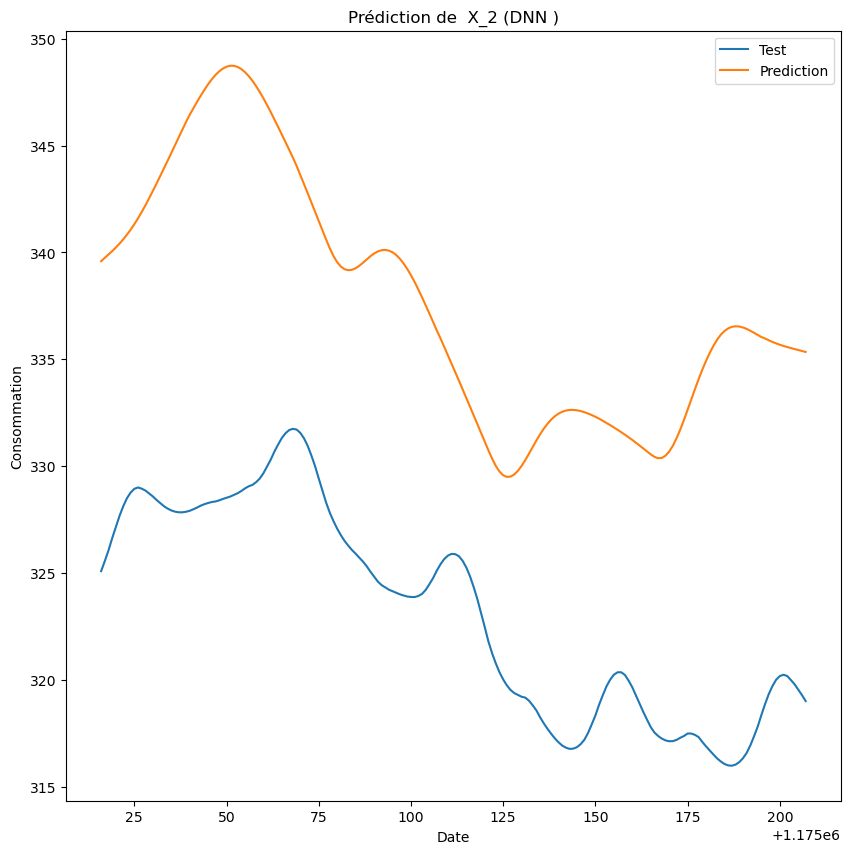

In [376]:
# # Affichage pour X_2 prédit par DNN


# MAP pour X_2
plt.figure(figsize=(10,10))
plt.plot(np.exp(y_test.values)/df['nb'].iloc[forceast_long-test_long:forceast_long], label ='Test')
plt.plot(np.exp(y_pred)/df['nb'].iloc[forceast_long-test_long:forceast_long], label ="Prediction")
#plt.plot((y_test.values-np.min(y_test.values))/(np.max(y_test.values)- np.min(y_test.values)), label ='Test')
#plt.plot((y_pred-np.min(y_pred))/(np.max(y_pred)- np.min(y_pred)), label ="Prediction")
#plt.plot(X_test[:,0], label = 'T')
#plt.plot(X_test[:,-1], label = 'R')
##plt.fill_between(prediction.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Prédiction de  X_2 (DNN )")
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.legend()

plt.show()

In [379]:
sub_df['Profil'].unique()

array(['RES11 (+ RES11WE)'], dtype=object)

In [378]:
sub_df.columns

Index(['Région', 'Code région', 'Profil', 'Plage de puissance souscrite',
       'Nb points soutirage', 'Total énergie soutirée (Wh)',
       'Courbe Moyenne n°1 (Wh)', 'Indice représentativité Courbe n°1 (%)',
       'Courbe Moyenne n°2 (Wh)', 'Indice représentativité Courbe n°2 (%)',
       'Courbe Moyenne n°1 + n°2 (Wh)',
       'Indice représentativité Courbe n°1 + n°2 (%)',
       'Jour max du mois (0/1)', 'Semaine max du mois (0/1)', 'AAAAMMJJHH',
       'T_moyenne', 'T_STD', 'T_min', 'T_q25', 'T_q50', 'T_q75', 'T_max',
       'T_skew', 'T_kurtosis', 'FF_moyenne', 'FF_STD', 'FF_min', 'FF_q25',
       'FF_q50', 'FF_q75', 'FF_max', 'U_moyenne', 'U_STD', 'U_min', 'U_q25',
       'U_q50', 'U_q75', 'U_max', 'date', 'year', 'month', 'month_n', 'day',
       'day_n', 'h', 'mn', 's', 'Rayonnement solaire global (W/m2)'],
      dtype='object')

In [439]:
np.sort([2,1,4])

array([1, 2, 4])

[ 22  44  88 132 176]


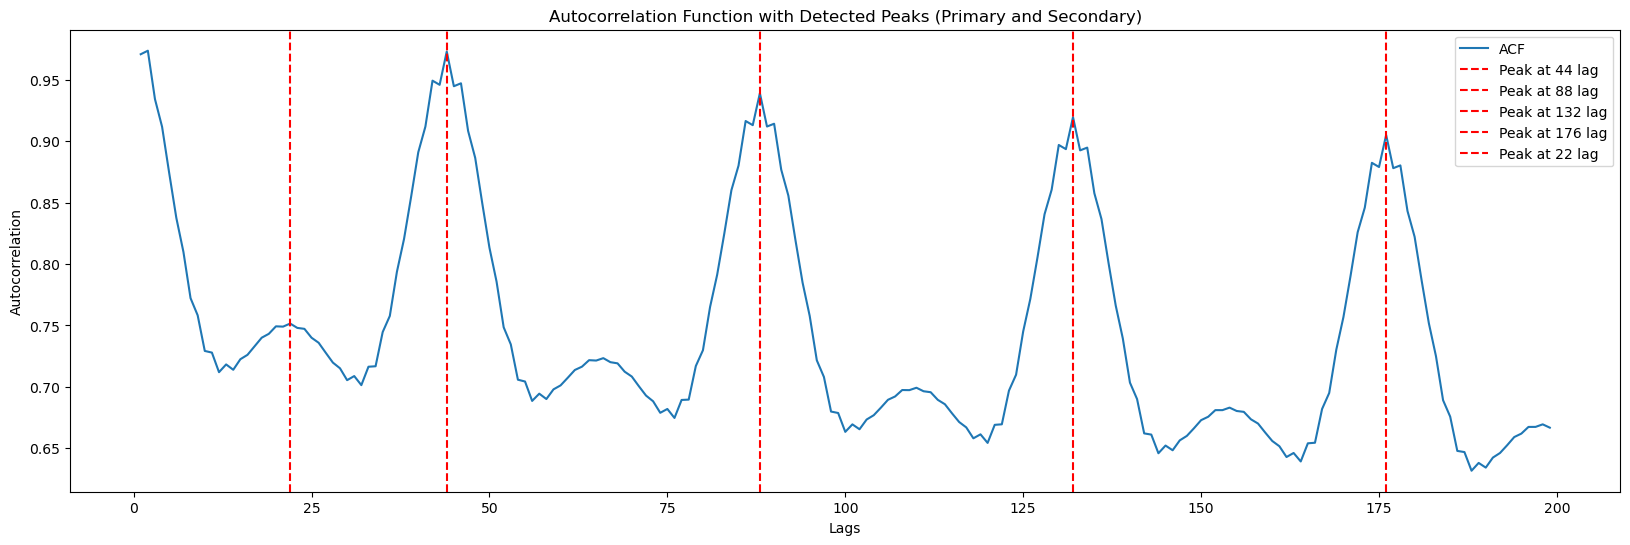

In [452]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import find_peaks

class ACFDominantFrequenciesOptimized(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=10, max_lag=500, height=0.01, distance=5, width=1, prominence=0.01):
        self.top_n = top_n
        self.max_lag = max_lag
        self.height = height
        self.distance = distance
        self.width = width
        self.prominence = prominence
        self.dominant_periods = None

    def fit(self, X, y=None):
        # Ensure the input is a pandas Series
        if not isinstance(X, pd.Series):
            raise ValueError("Input must be a pandas Series.")

        # Compute Autocorrelation
        acf_values = pd.Series([X.autocorr(lag) for lag in range(1, self.max_lag)])
        acf_values.index += 1  # To match the lag values

        # Detecting peaks (primary and secondary)
        peaks, properties = find_peaks(acf_values, height=self.height, distance=self.distance, width=self.width, prominence=self.prominence)

        # Sorting peaks by height and including small peaks
        peak_values = acf_values.iloc[peaks]
        self.dominant_periods = peak_values.nlargest(self.top_n).index

        return self

    def transform(self, X):
        if self.dominant_periods is None:
            raise ValueError("Model has not been fitted yet.")

        return pd.DataFrame({
            'Dominant Periods (Lags)': self.dominant_periods
        })

    def plot_acf(self, X):
        acf_values = pd.Series([X.autocorr(lag) for lag in range(1, self.max_lag)])
        acf_values.index += 1

        plt.figure(figsize=(20, 6))
        plt.plot(acf_values, label="ACF")

        # Highlighting the detected peaks
        for peak in self.dominant_periods:
            plt.axvline(x=peak, color='red', linestyle='--', label=f'Peak at {peak} lag')

        plt.title("Autocorrelation Function with Detected Peaks (Primary and Secondary)")
        plt.xlabel("Lags")
        plt.ylabel("Autocorrelation")
        plt.legend()
        plt.show()


# Example Usage
if __name__ == '__main__':
    # Load your data
    y = sub_df['Total énergie soutirée (Wh)']

    # Initialize and fit the extractor
    extractor = ACFDominantFrequenciesOptimized(
        top_n=5, 
        max_lag=200, 
        height=0.01, 
        distance=5, 
        width=1, 
        prominence=0.01
    )
    extractor.fit(y)

    # Display dominant periods (including small peaks)
    print(np.sort(extractor.transform(y)['Dominant Periods (Lags)']))

    # Plot the ACF with detected peaks (including small peaks)
    extractor.plot_acf(y)

    Top 1 Frequency  Top 2 Frequency  Top 3 Frequency  Top 4 Frequency  \
0               0.0              4.0              7.0             11.0   
1               0.0              4.0             42.0             81.0   
2               0.0              4.0             42.0             81.0   
3               0.0              4.0             81.0             42.0   
4               0.0              4.0             81.0             84.0   
..              ...              ...              ...              ...   
68              0.0              4.0              7.0             42.0   
69              0.0              4.0             81.0             42.0   
70              0.0              4.0             42.0             81.0   
71              0.0              4.0             42.0             39.0   
72              0.0              4.0              7.0             11.0   

    Top 5 Frequency  Top 6 Frequency  Top 7 Frequency  Top 8 Frequency  \
0              14.0             18.0 

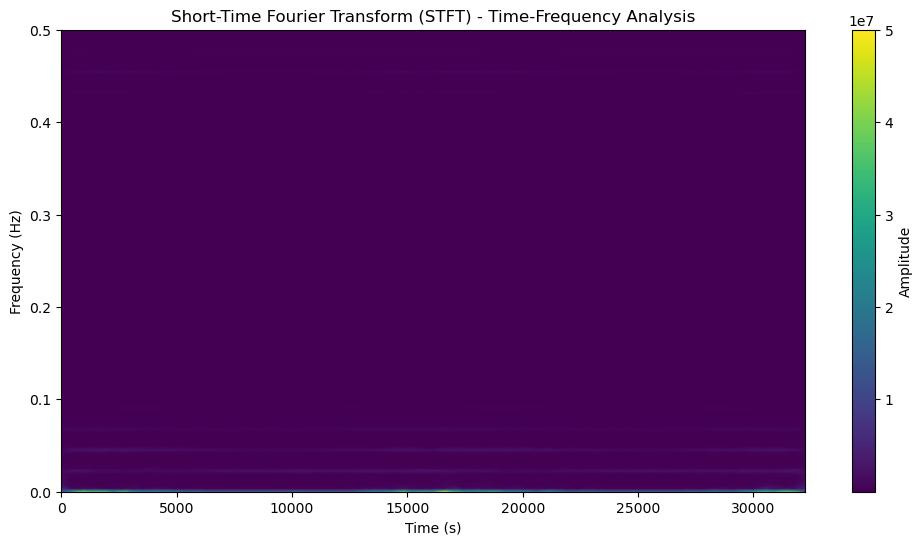

In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import find_peaks

class ACFDominantFrequenciesOptimized(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=10, max_lag=500):
        self.top_n = top_n
        self.max_lag = max_lag
        self.height = None
        self.distance = None
        self.width = None
        self.prominence = None
        self.dominant_periods = None
        self.coherent_periods = None

    def fit(self, X, y=None):
        # Ensure the input is a pandas Series
        if not isinstance(X, pd.Series):
            raise ValueError("Input must be a pandas Series.")

        # Compute Autocorrelation
        acf_values = pd.Series([X.autocorr(lag) for lag in range(1, self.max_lag)])
        acf_values.index += 1  # To match the lag values

        # Adaptive height and prominence
        acf_mean = acf_values.mean()
        acf_std = acf_values.std()
        self.height = acf_mean + 0.1 * acf_std
        self.prominence = 0.05 * (acf_values.max() - acf_values.min())

        # Initial peak detection (large peaks)
        peaks, _ = find_peaks(acf_values, height=self.height, prominence=self.prominence)

        # Secondary peak detection (smaller peaks between primary)
        secondary_peaks, _ = find_peaks(acf_values, height=acf_mean, prominence=0.01 * acf_values.max(), distance=5)

        # Combine and sort all detected peaks
        all_peaks = np.unique(np.concatenate((peaks, secondary_peaks)))
        peak_values = acf_values.iloc[all_peaks]
        self.dominant_periods = peak_values.nlargest(self.top_n).index

        # Analyzing distances between peaks to find coherent periods
        periods = np.diff(self.dominant_periods)
        self.coherent_periods = pd.Series(periods).value_counts().nlargest(3).index.values

        return self

    def transform(self, X):
        if self.dominant_periods is None:
            raise ValueError("Model has not been fitted yet.")

        return pd.DataFrame({
            'Dominant Periods (Lags)': self.dominant_periods,
            'Coherent Periods': [self.coherent_periods]
        })

    def plot_acf(self, X):
        acf_values = pd.Series([X.autocorr(lag) for lag in range(1, self.max_lag)])
        acf_values.index += 1

        plt.figure(figsize=(12, 6))
        plt.plot(acf_values, label="ACF")

        # Highlighting the detected peaks
        for peak in self.dominant_periods:
            plt.axvline(x=peak, color='red', linestyle='--', label=f'Peak at {peak} lag')

        plt.title("Autocorrelation Function with Detected Peaks (Primary and Secondary)")
        plt.xlabel("Lags")
        plt.ylabel("Autocorrelation")
        plt.legend()
        plt.show()

    def get_coherent_periods(self):
        if self.coherent_periods is None:
            raise ValueError("Model has not been fitted yet.")

        return self.coherent_periods

# Example Usage
if __name__ == '__main__':
    # Load your data
    y = sub_df['Total énergie soutirée (Wh)']
    # Initialize and fit the STFT extractor
    stft_extractor = STFTDominantFrequencies(window='hamming', nperseg=512, noverlap=64, top_n=15)
    stft_extractor.fit(y)

    # Display dominant frequencies over time
    print(np.round(1800*stft_extractor.transform(y)))

    # Plot the STFT
    stft_extractor.plot_stft(y)


In [ ]:

sub_def = df.loc[(df['Profil']=='ENT3 (+ ENT4 + ENT5)')]'P0: Total <= 36 kVA'
sub_def['Plage de puissance souscrite'].unique()
#df['Profil'].unique()

array(['P0: Total <= 36 kVA'], dtype=object)

   Périodes
0     336.0
1      42.0
2      22.0


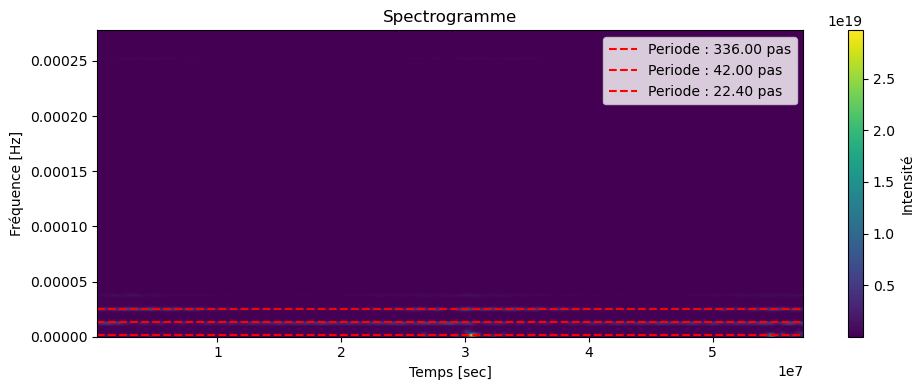

Fréquences des raies spectrales (X pas de 30 minutes) : [336.  42.  22.]


In [608]:
from analysespectrale import SpectrogramAnalysis
# Exemple d'utilisation
sub_def = df.loc[(df['Profil']=='ENT3 (+ ENT4 + ENT5)') & (df['Plage de puissance souscrite']=='P0: Total <= 36 kVA')]
    # Charger votre série temporelle
yy =  sub_df['Total énergie soutirée (Wh)']

# Initialiser et ajuster l'analyse du spectrogramme
spectrogram_analyzer = SpectrogramAnalysis(window='hann', nperseg=7*48, noverlap=2*48, fs= 1/1800, threshold=0.25)
spectrogram_analyzer.fit(yy)
TT = spectrogram_analyzer.transform(yy)
print(TT)
spectrogram_analyzer.plot_spectrogramme()
    # Transformer pour obtenir les fréquences dominantes

print("Fréquences des raies spectrales (X pas de 30 minutes) :", spectrogram_analyzer.dominant_periodes)


In [566]:
spectrogram_analyzer.spectrogram

array([[8.45813579e+17, 2.03616023e+18, 6.54979791e+17, ...,
        6.90320014e+17, 8.06766257e+16, 4.18623007e+18],
       [2.03660210e+18, 9.13103315e+18, 1.53613493e+19, ...,
        2.14393666e+18, 8.65949990e+18, 1.60885222e+19],
       [3.98946024e+17, 7.48130565e+17, 3.30430483e+18, ...,
        1.63155089e+18, 2.69900513e+19, 1.02247579e+19],
       ...,
       [2.29751988e+14, 1.55649112e+14, 7.37717217e+13, ...,
        2.36058007e+14, 4.80546276e+15, 7.41064453e+14],
       [5.97338214e+14, 1.03947872e+15, 1.48840183e+15, ...,
        1.52053449e+15, 2.53093201e+15, 2.79839275e+14],
       [6.58360315e+14, 1.59601043e+15, 1.01368912e+15, ...,
        1.41653639e+15, 1.55042999e+15, 7.52020245e+14]])